# TP 1 - Différences finies

Julien BLANCHON

# Objectif du TP

L’objectif de ce TP est de résoudre l’équation d’advection 1D à l’aide de plusieurs schémas différences finies. On rappelle que cette équation d’advection 1D peut s’écrire :

$$\frac{\partial u}{\partial t}+a \frac{\partial u}{\partial x}=0$$

L’implémentation des différents schémas se fera dans un script Python.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Matplotlib formating
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.constrained_layout.use'] = True

# 1 - Construction et visualisation du maillage et de la condition initiale

On considère un domaine 1D de longueur L, discrétisé en $m$ points. Les deux conditions initiales envisagées sont
les suivantes :

**CI1** : $u^{0}=\sin \left(\frac{2 \beta x_{i}}{L}\right)$, où $\beta$ est le numéro du mode considéré.

**CI2** : $u^{0}=0 \text { si } x<x_{0}, u^{0}=1 \text { sinon. }$

Pour commencer, on choisira les valeurs numériques suivantes : $L = 1$, $m = 100$.

In [3]:
# Configuration par defaut
L = 1.0  # Longeur L, 1.0 par défaut
m = 100  # Nombre de point de discrétisation m, par défaut 100
X = np.linspace(start=0, stop=L, num=m)
# X = np.array([i*(L/(m-1)) for i in range(m)])
delta_x = L/(m-1)

Construire les tableaux x, contenant les abscisses des points du maillage, et $u_0$, la solution initiale, puis les
visualiser avec Matplotlib.

In [4]:
# Condition initiale
## Fonction CI1
def CI1(X:np.ndarray, beta:float=2) -> np.ndarray:
    u_zero = np.sin((2*beta*X*np.pi)/L)
    return u_zero

## Fonction CI2
def CI2(X: np.ndarray, x0: float = 0.5) -> np.ndarray:
    u_zero = np.array([(0 if xi < x0 else 1) for xi in X])
    return u_zero

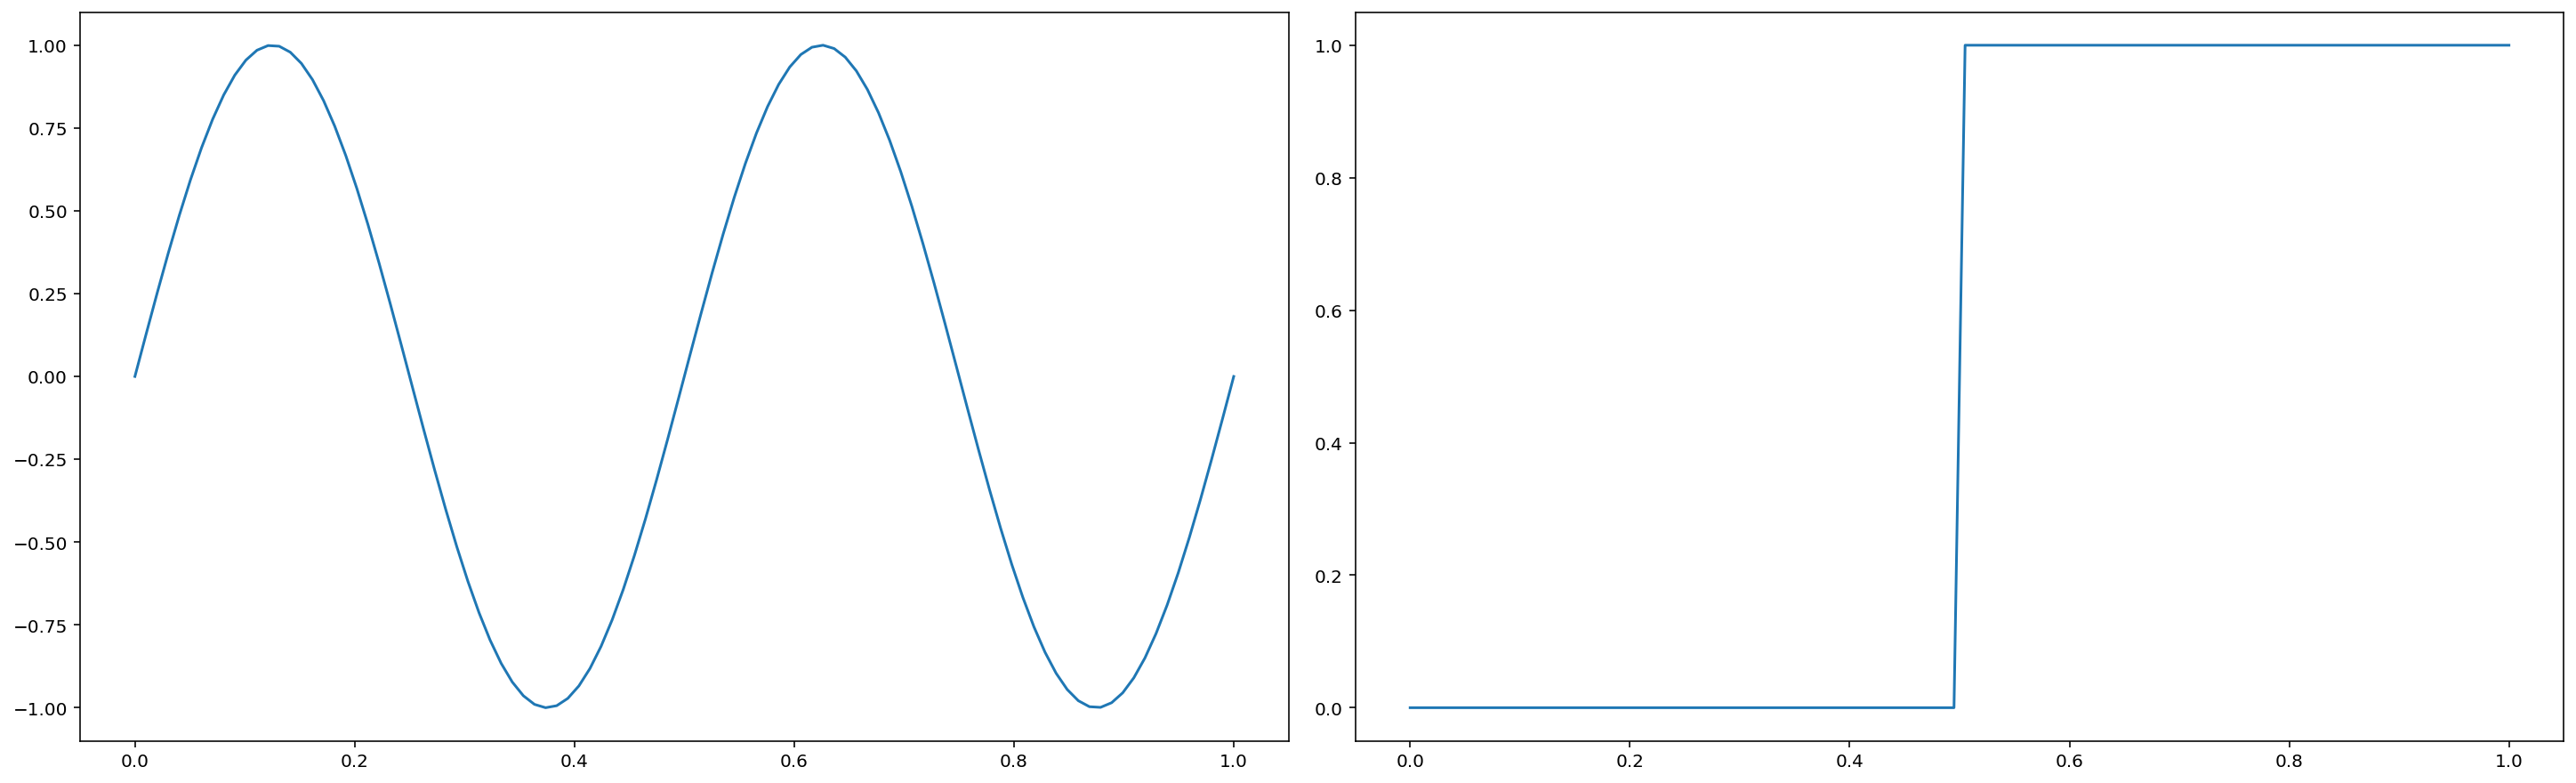

In [5]:
# Plot condition initiale
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
u_zero = CI1(X, beta=2)
ax1.plot(X, CI1(X, beta=2))
ax2.plot(X, CI2(X, x0=0.5))
plt.show()

# 2 - Étude du comportement de schémas différences finies

## 2.1 Paramètres physiques et numériques

Par la suite, on considèrera le problème physique suivant (sauf indication contraire dans l’énoncé) :
- Vitesse de convection $a = 1$
- Conditions limites périodiques en espace
- Solution observée au terme d’un temps $T$ lui permettant de revenir à sa position initiale.

On rappelle que le nombre de Courant, noté $\mathcal{C}$, est défini comme :

$$\mathcal{C}=\frac{a \Delta t}{\Delta x}$$

Ce nombre sera pris égal à $0.5$ par défaut.

In [6]:
# Configuration exemple Courant
C = 0.5 # nombre de Courant, 0.5 par défaut
a = 1 # Vitesse de convection, 1 par défaut
delta_t = C*delta_x/np.abs(a)

## 2.2 Méthodologie

In [7]:
## Fonction pour avoir u_i de façon cyclique, l'usage de np.roll est finalement préféré
# def get_u_i(u:np.ndarray, i:int) -> float:
#     I = u.shape[0]
#     if 0 <= i < I:
#         return u[i]
#     else:
#         return get_u_i(u, i%I)

### Rappel du schéma semi-discret **FOU** (schéma décentré amont, $a+$):

$$\frac{d u}{d t}=-\frac{a}{\Delta x}\left(u_{i}-u_{i-1}\right)$$

En intégration temporelle d'`Euler Explicite`
$$u_{i}^{n+1}=u_{i}^{n}-\mathcal{C}\left(u_{i}^{n}-u_{i-1}^{n}\right)$$

- Conditionnelle stable pour $a>0$
- Inconditionellement instable pour $a<0$
- Facteur d'amplification : $\mathcal{G} = 1-\mathcal{C}+\mathcal{C} \cos \varphi-\mathrm{j} \mathcal{C} \sin \varphi \implies 0 \leq \mathcal{C} \leq 1$ pour $a>0$
- Condition de Stabilité: $a>0$ et $0 \leq \mathcal{C} \leq 1$
- Ordre 1 en espace
- Schéma décentré amont ($+$)

In [8]:
def FOU_EE(ui, C=0.5):
    ui_plus = ui - C*(ui - np.roll(ui, shift=+1))
    return ui_plus

### Rappel du schéma semi-discret **FOF** :

$$\frac{d u}{d t}=-\frac{a}{\Delta x}\left(u_{i+1}-u_{i}\right)$$

En intégration temporelle d'`Euler Explicite`

$$u_{i}^{n+1}=u_{i}^{n}-\mathcal{C}\left(u_{i+1}^{n}-u_{i}^{n}\right)$$


- Conditionnelle stable pour $a<0$
- Inconditionellement instable pour $a>0$
- Condition de Stabilité: $a<0$ et $0 \leq \mathcal{C} \leq 1$
- Ordre 1 en espace
- Schéma décentré aval ($-$)

In [9]:
def FOF_EE(ui, C=0.5):
    ui_plus = ui - C*(np.roll(ui, shift=-1) - ui)
    return ui_plus


### Rappel du schéma semi-discret **SOC** :

$$\frac{d u}{d t}=-\frac{1}{2}\frac{a}{\Delta x}\left(u_{i+1}-u_{i-1}\right)$$

En intégration temporelle d'`Euler Explicite`

$$u_{i}^{n+1}=u_{i}^{n}-\frac{\mathcal{C}}{2}\left(u_{i+1}^{n}-u_{i-1}^{n}\right)$$

- Inconditionellement instable pour tout $a$
- Facteur d'amplification $|\mathcal{G}|=\sqrt{1^{2}+(\mathcal{C} \sin \varphi)^{2}}=\sqrt{1^{2}+\mathcal{C}^{2} \sin ^{2} \varphi} \geq 1$
- Condition de Stabilité: ø
- Ordre 1 en espace
- Schéma centré ($=$)

In [10]:
def SOC_EE(ui, C=0.5):
    ui_plus = ui - 0.5*C*(np.roll(ui, shift=-1) - np.roll(ui, shift=+1))
    return ui_plus


### Rappel du schéma semi-discret **Lax_Wendroff** :

$$\frac{d u}{d t}=-\frac{1}{2}\frac{a}{\Delta x}\left(u_{i}-u_{i-1}\right) + \frac{1}{2}\left(\frac{a}{\Delta x}\right)^2\left(u_{i+1}-2u_{i} + u_{i-1}\right)$$


En intégration temporelle d'`Euler Explicite`

$$u_{i}^{n+1}=u_{i}^{n}-\frac{\mathcal{C}}{2}\left(u_{i+1}^{n}-u_{i-1}^{n}\right)+\frac{\mathcal{C}^{2}}{2}\left(u_{i+1}^{n}-2 u_{i}^{n}+u_{i-1}^{n}\right)$$

- Condition de Stabilité: $0 \leq \mathcal{C} \leq 1$

In [11]:
def Lax_Wendroff_EE(ui, C=0.5):
    ui_plus = ui - 0.5*C*(np.roll(ui, shift=-1) - np.roll(ui, shift=+1)) + \
        0.5*C**2*(np.roll(ui, shift=-1) - 2*ui + np.roll(ui, shift=+1))
    return ui_plus


Pour chaque schéma numérique implémenté, on répondra aux questions suivantes :
- Visualiser les solutions obtenues en partant de la condition initiale CI1, en utilisant successivement des valeurs
de $n$ égales à $2$, $4$, $8$ et $16$ et noter vos observations.
- Pour la condition initiale correspondant à $n = 1$, réaliser des simulations avec les nombres $\mathcal{C}$ égaux à $0.1$, $0.2$, $0.4$, $0.8$, $1$, $1.5$ et noter vos observations.
- Utiliser maintenant la condition initiale CI2. Sortir la solution à $\mathcal{C} = 1$ aux instants suivants : $T/4$, $T/2$, $T/2$ et enfin $T$.
- Refaire l’étude sur l’influence du nombre $\mathcal{C}$ avec la condition initiale CI2.
- Toujours avec CI2 et $\mathcal{C} = 0.1$, étudiez l’influence de la discrétisation spatiale sur le résultat en prenant successivement un nombre de points m égal à $4$, $10$, $20$, $50$, $100$ et $200$.
- Que se passe-t-il si l’on change le signe de a ?

In [12]:
def plot_sol(schema=FOU_EE, function_name='CI1', L=1, m=50, C=1.0, a=1.0, beta=1, x0=1.0, P=1, 
            trace=False, save=False, show=True, ax=plt):
    X = np.linspace(start=0, stop=L, num=m)
    if function_name == "CI1":
        CI = CI1
        u0 = CI(X, beta)
    elif function_name == "CI2":
        CI = CI2
        u0 = CI(X, x0)
    else:
        CI = function_name
        u0 = CI(X)
    
    delta_x = L/(m-1)
    delta_t = C*delta_x/np.abs(a)
    tMax = int(1/delta_t)
    tMax = int(tMax/P)
    C = np.sign(a)*C

    # t = t_0
    ut = u0
    ax.plot(X, ut)

    # t = t_i
    for t in range(tMax):
        ut = schema(ut, C)
        if trace:
            ax.plot(X, ut, c=(t/tMax, 0., 0.), alpha=0.01)

    # t = t_max
    ut = schema(ut, C)
    ax.plot(X, ut)
    ax.grid()
    if ax==plt:
        ax.title(
            f"{CI.__name__}, {schema.__name__}, L={L}, m={m}, C={C}, a={a}, beta={beta}, x0={x0}, Tmax{P}")
        if save:
            ax.savefig(
                f"{CI.__name__}__{schema.__name__}__L={L}__m={m}__C={C}__a={a}__beta={beta}__x0={x0}__Tmax{P}.png")
        if show:
            ax.show()

Visualiser les solutions obtenues en partant de la condition initiale CI1, en utilisant successivement des valeurs
de $n$ égales à $2$, $4$, $8$ et $16$ et noter vos observations.

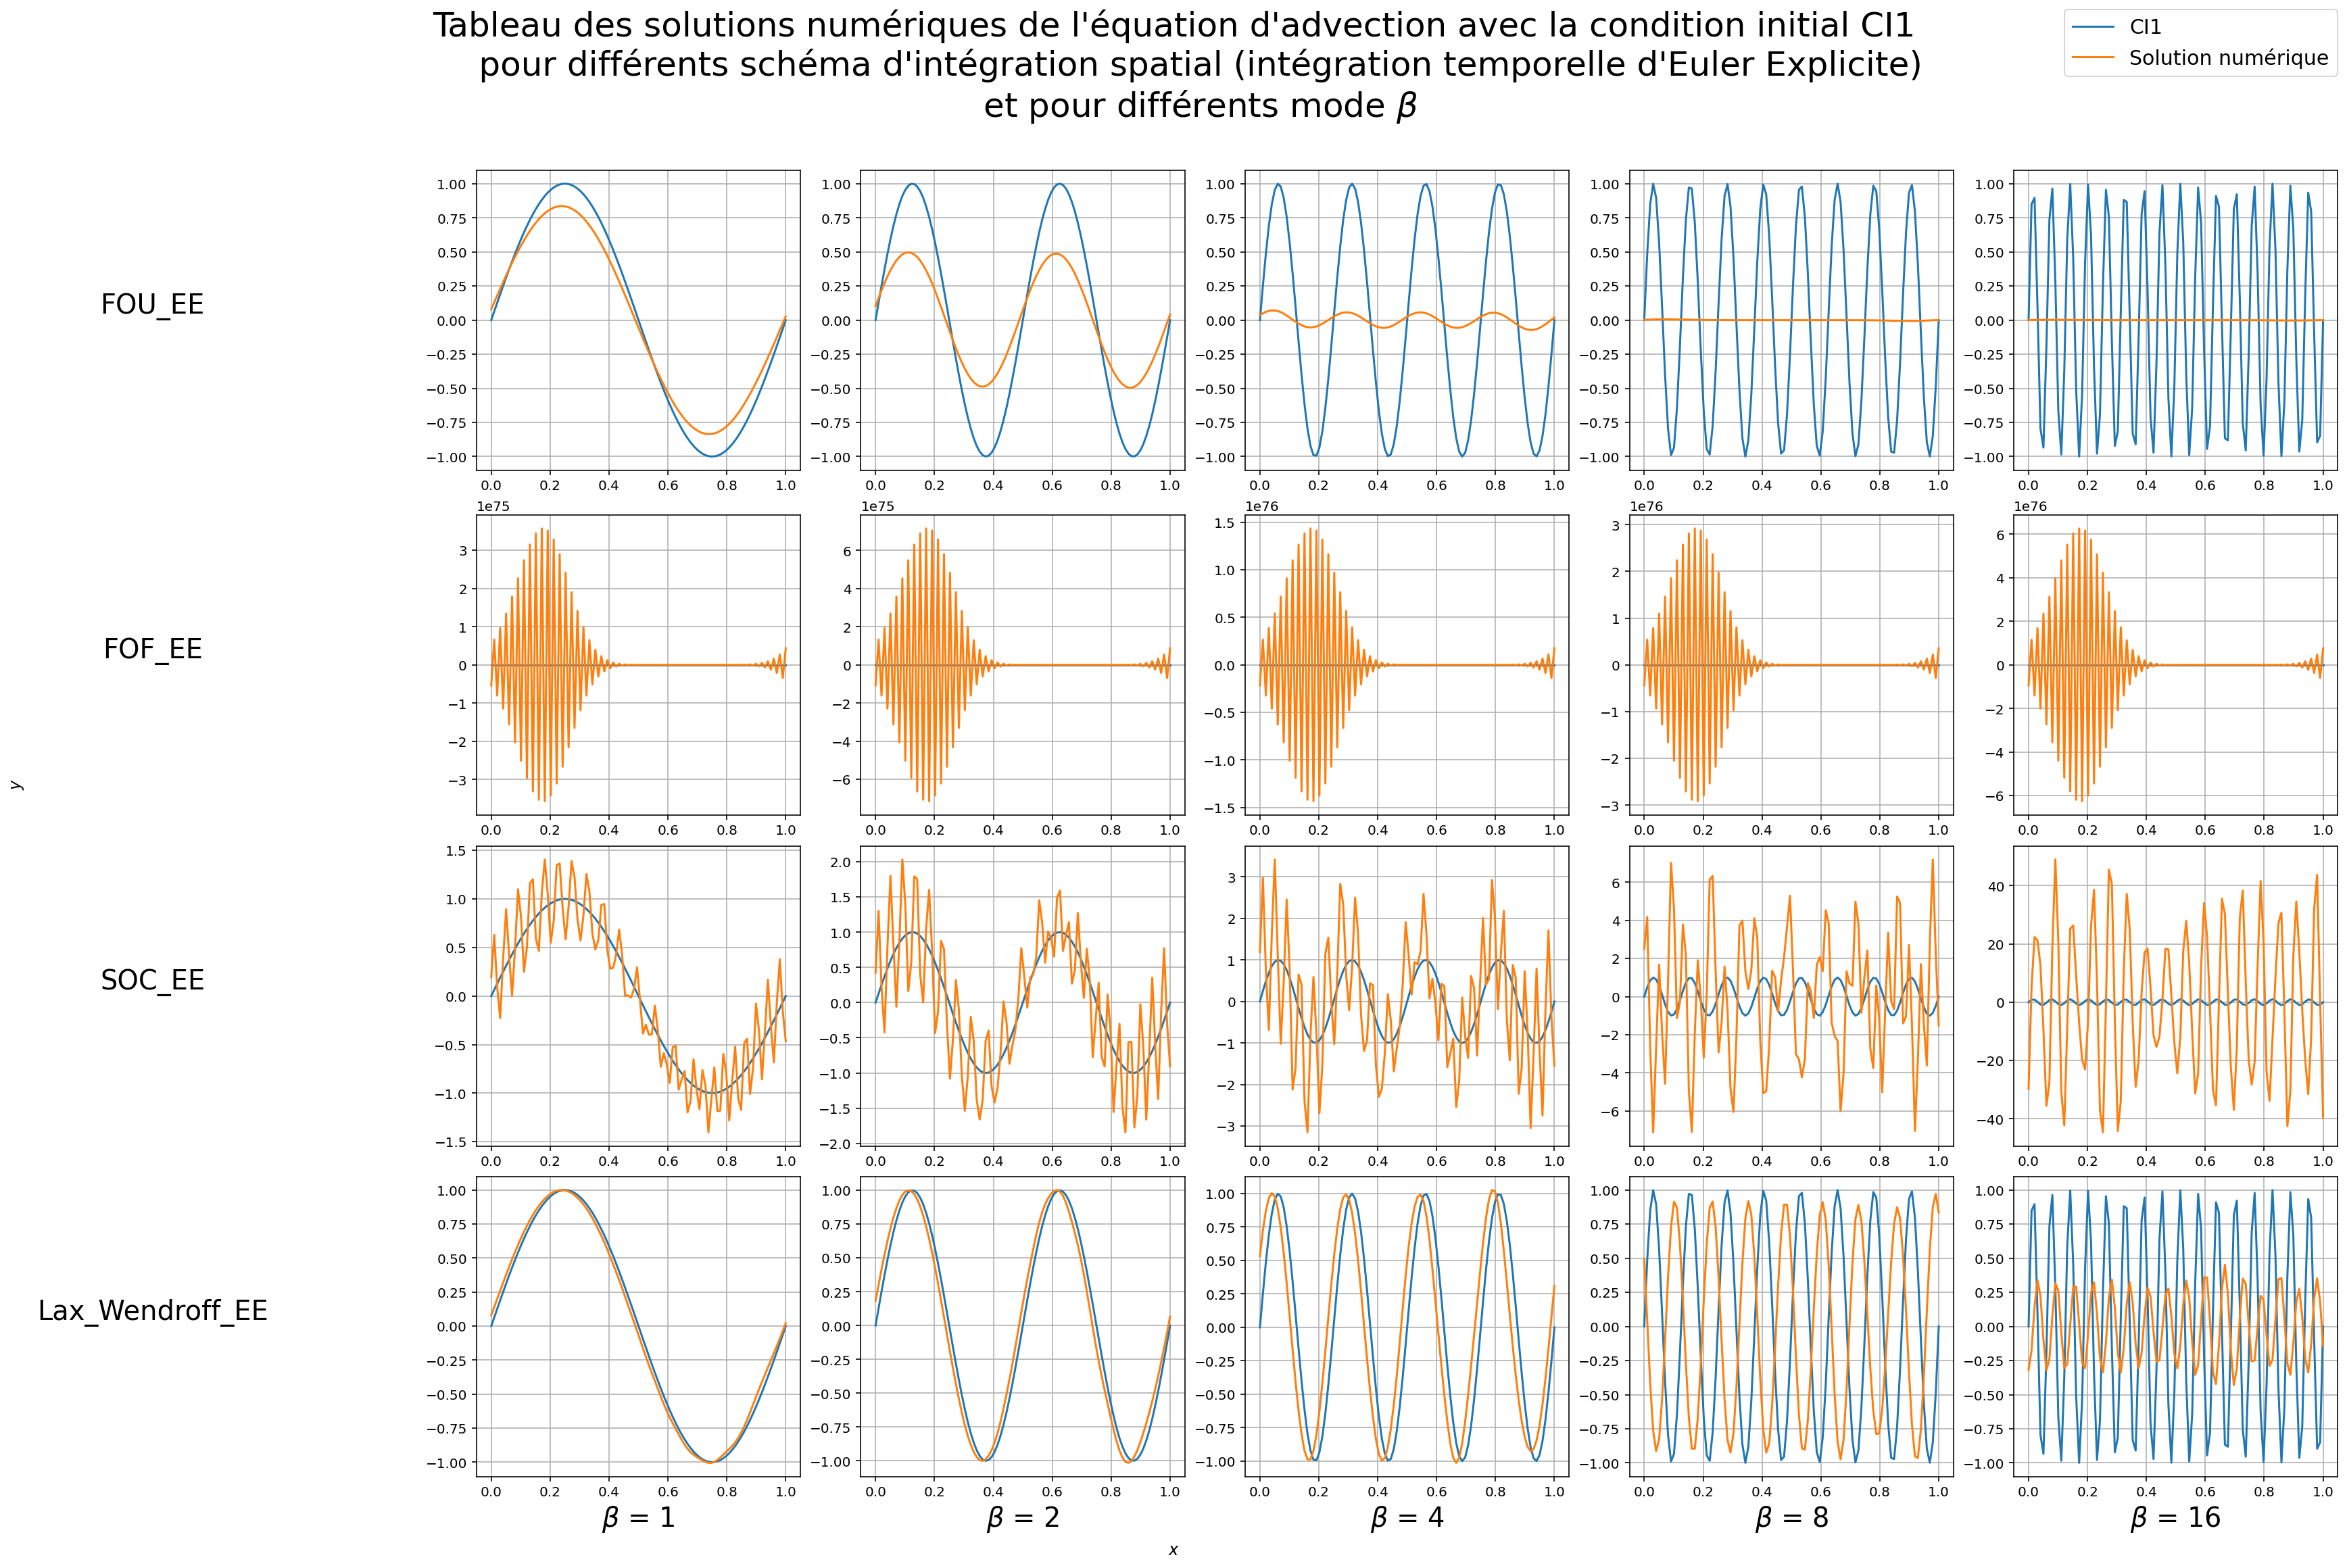

In [13]:
# Variation des solutions selon le mode beta

beta_list = [1, 2, 4, 8, 16]
schema_list = [FOU_EE, FOF_EE, SOC_EE, Lax_Wendroff_EE]

fig, axs = plt.subplots(nrows=len(schema_list),
                        ncols=len(beta_list), figsize=(24, 16))
fig.suptitle(
    "Tableau des solutions numériques de l'équation d'advection avec la condition initial CI1\n \
    pour différents schéma d'intégration spatial (intégration temporelle d'Euler Explicite)\n \
    et pour différents mode $\\beta$\n", fontsize=25)
fig.supxlabel("$x$")
fig.supylabel("$y$")

for i, schema in enumerate(schema_list):
    axs[i, 0].set_ylabel(f"{schema.__name__}", rotation=0,
                         size=20)
    axs[i, 0].yaxis.set_label_coords(-1, 0.5)
    for j, beta in enumerate(beta_list):
        axs[-1, j].set_xlabel(f"$\\beta$ = {beta}", rotation=0,
                             size=20)
        plot_sol(schema=schema, function_name='CI1', L=1,
                 m=100, C=0.1, a=1.0, beta=beta, x0=0.5, P=1, ax=axs[i, j], trace=False)
fig.legend([f"CI1", f"Solution numérique"], fontsize=15)
plt.show()


Pour les quatres schéma (`FOU_EE`, `FOF_EE`, `SOC_EE`, `Lax_Wendroff_EE`), la périodicité temporelles de la solution numérique est bien maintenus pour tout les modes, sauf pour `FOF_EE` qui est un schéma "aval" et n'est donc pas correcte dans le contexte $a \ge 0$ (a l'inverse `FOU_EE` le pendant de `FOF` mais en "amont" fonctionne ici très bien).

Il semble y avoir un déphasage d'une unité de temps, cela est potentiellement du à une erreur d'arrondie de la période de périodicité.

Pour `FOU_EE`: La signal de la solution numérique est d'autant plus atténué que le mode est grand. Ici pour $\beta = 8$ le résultat commence déjà à être très mauvais. Le problème viens du fait que `FOU_EE` est d'ordre 1 en espace pour avoir un meilleurs intégration numérique avec ce même schéma il nous faut un maillage plus fin.

Pour `FOF_EE`: C'est un simulacre, le schéma n'est pas correcte dans ce contexte ...

Pour `SOC_EE`: Signal solution avec énormement de bruit, par transformée de Fourier on vois bien que le signal contiens une relativement grande composantes sur la fréquence sinusoïde de la solution théorique (mais d'autre fréquence viennes aussi parasité le signal). Cela est du au fait qu'il est inconditionellement instable avec comme facteur d'amplification $|\mathcal{G}|=\sqrt{1^{2}+(\mathcal{C} \sin \varphi)^{2}}=\sqrt{1^{2}+\mathcal{C}^{2} \sin ^{2} \varphi} \geq 1$.

Pour `Lax_Wendroff_EE`: Super bonne intégration spatiale pour $\beta = 1$, $\beta = 2$ et même $\beta = 4$, ordre 2 en espace. Cependant cela n'aura pas suffit pour $\beta = 8$ et $\beta = 16$.

- Pour la condition initiale correspondant à $n = 1$, réaliser des simulations avec les nombres $\mathcal{C}$ égaux à $0.1$, $0.2$, $0.4$, $0.8$, $1$, $1.5$ et noter vos observations.

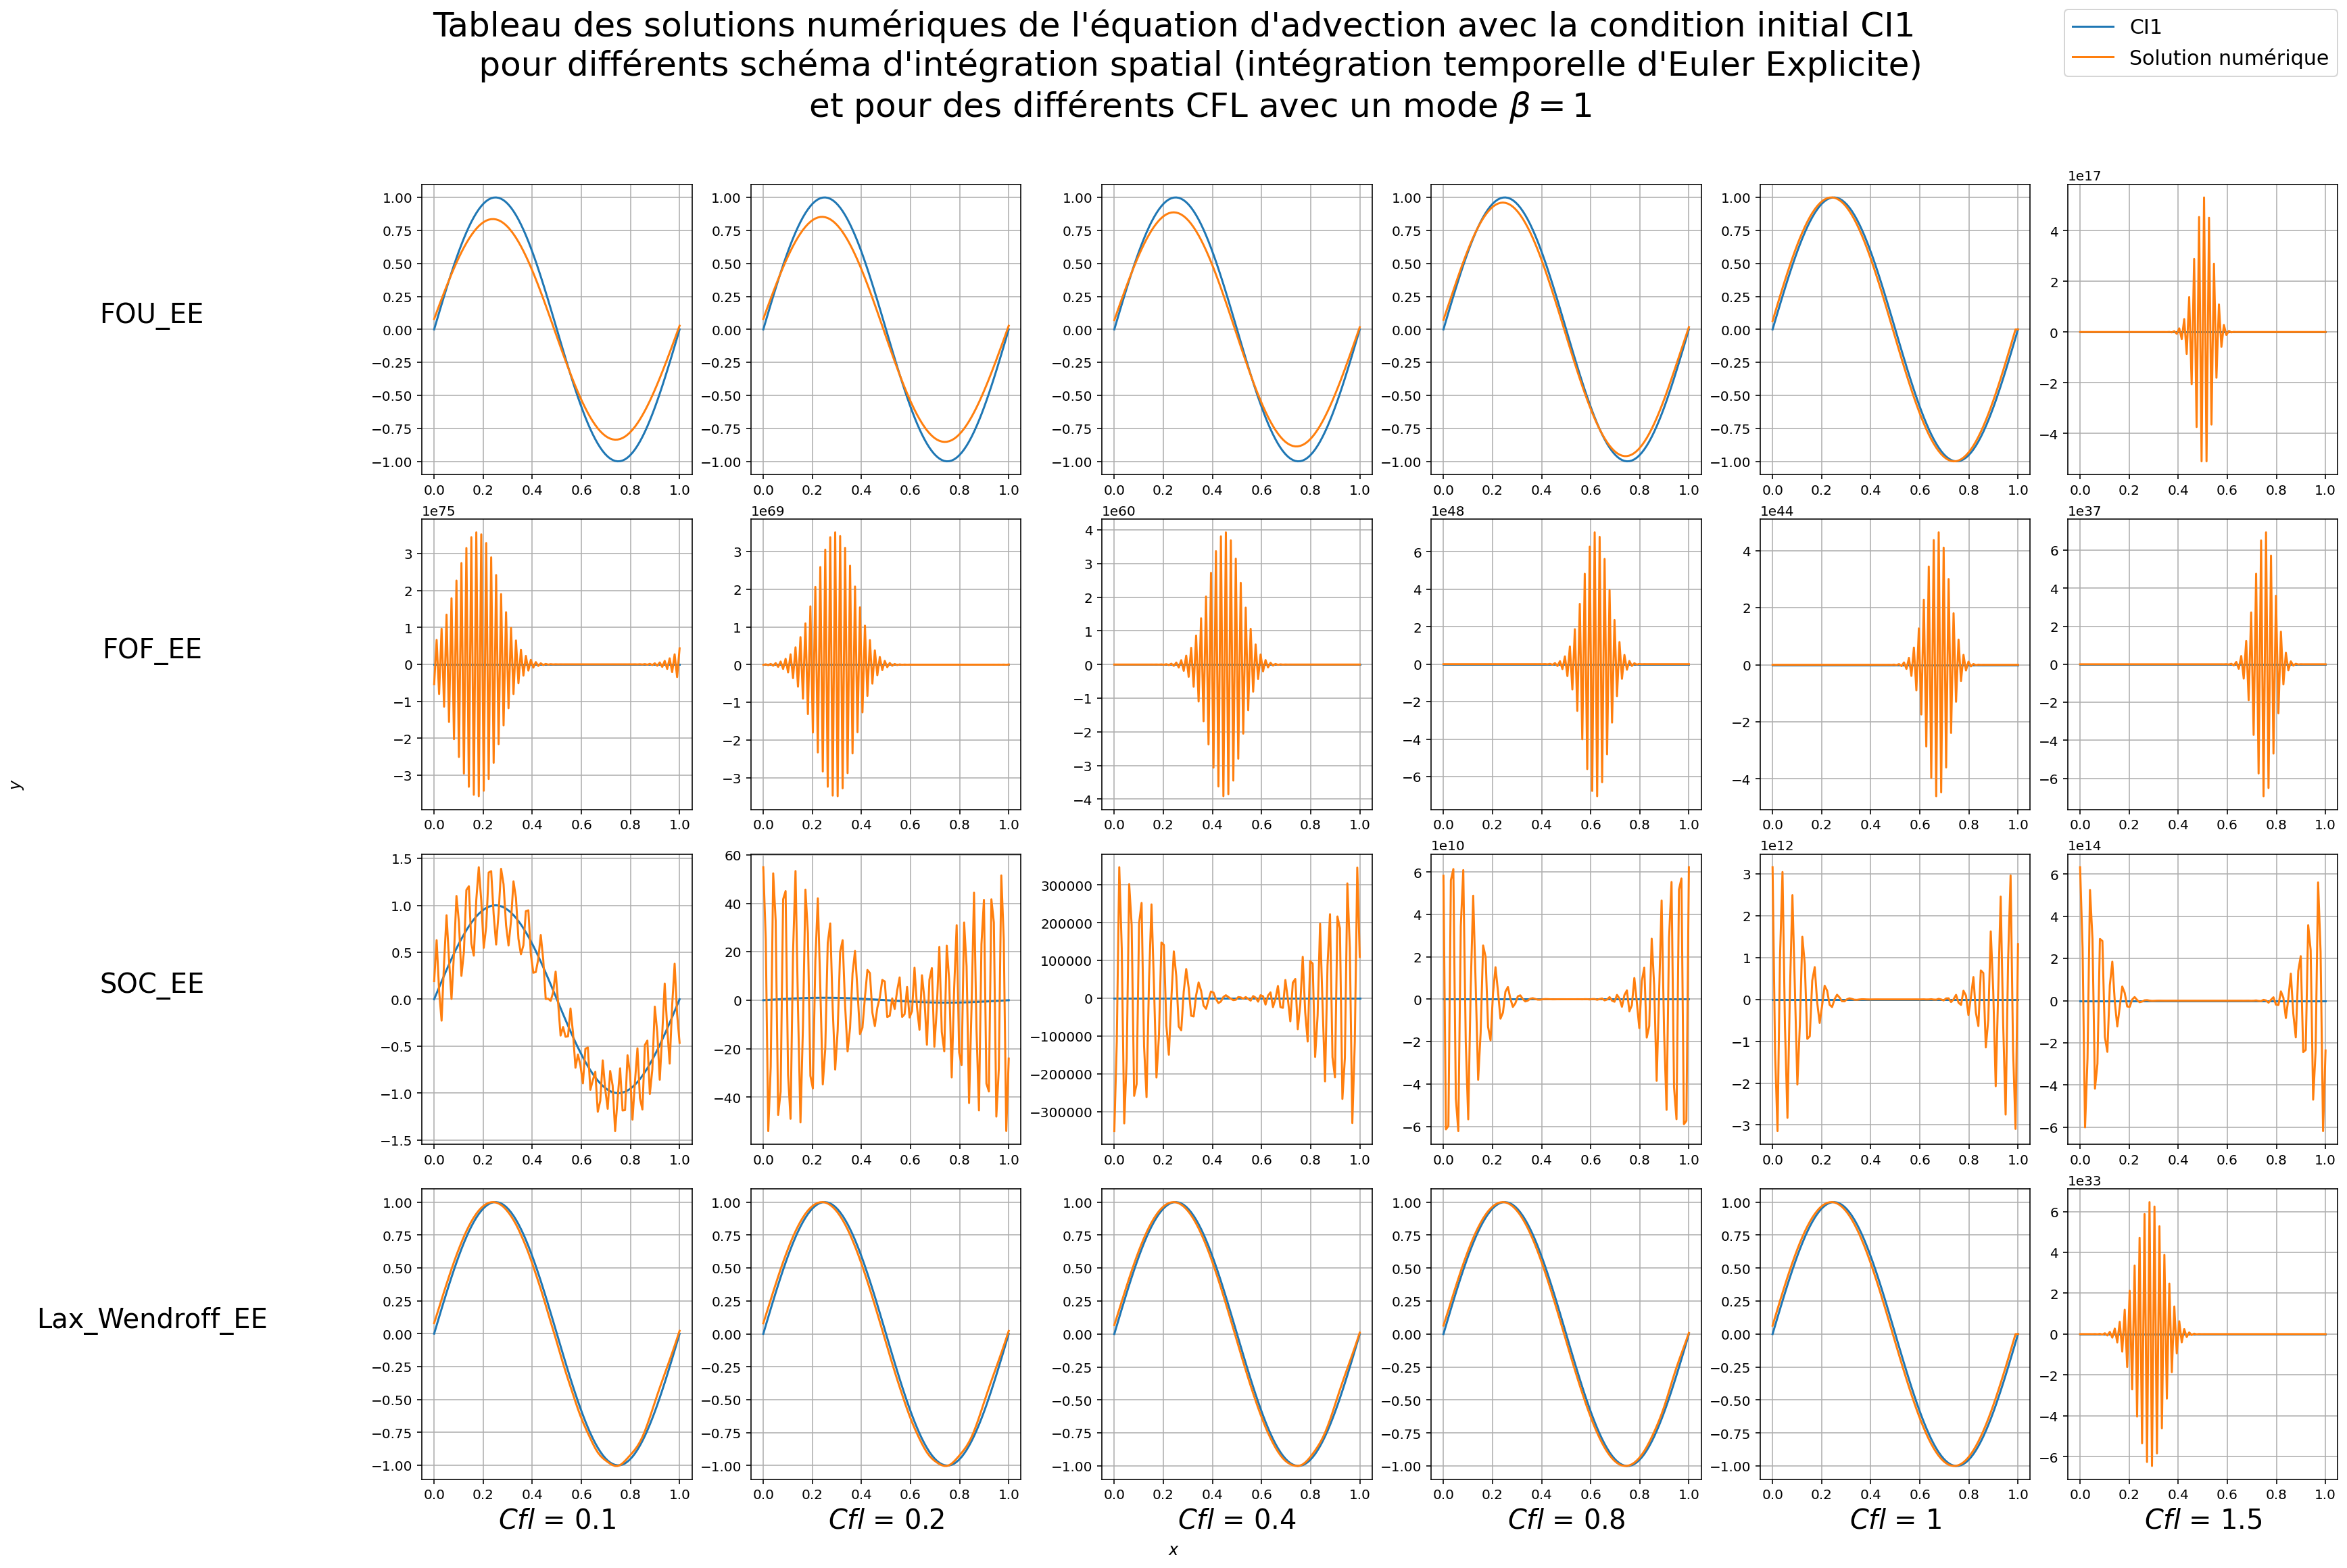

In [14]:
# Variation des solutions selon CFL

cfl_list = [0.1, 0.2, 0.4, 0.8, 1, 1.5]
schema_list = [FOU_EE, FOF_EE, SOC_EE, Lax_Wendroff_EE]

fig, axs = plt.subplots(nrows=len(schema_list),
                        ncols=len(cfl_list), figsize=(24, 16))
fig.suptitle(
    "Tableau des solutions numériques de l'équation d'advection avec la condition initial CI1\n \
    pour différents schéma d'intégration spatial (intégration temporelle d'Euler Explicite)\n \
    et pour des différents CFL avec un mode $\\beta = 1$\n", fontsize=25)
fig.supxlabel("$x$")
fig.supylabel("$y$")
for i, schema in enumerate(schema_list):
    axs[i, 0].set_ylabel(f"{schema.__name__}", rotation=0,
                         size=20)
    axs[i, 0].yaxis.set_label_coords(-1, 0.5)
    for j, cfl in enumerate(cfl_list):
        axs[-1, j].set_xlabel(f"$Cfl$ = {cfl}", rotation=0,
                              size=20)
        plot_sol(schema=schema, function_name='CI1', L=1,
                 m=100, C=cfl, a=1.0, beta=1, x0=0.5, P=1, ax=axs[i, j])
fig.legend([f"CI1", f"Solution numérique"], fontsize=15)
plt.show()

Plusieurs phénomène semble être a l'oeuvre, les solutions sont d'autant plus bonne que $\mathcal{C}$ est proche de $1$ et certains schéma sorte parfois de leur condition de stabilités.

Pour `FOU_EE`: La condition de Stabilité est $a>0$ et $0 \leq \mathcal{C} \leq 1$. La solution diverge pour le $\mathcal{C} = 1.5 > 1$, ce qui s'explique par la condition de Stabilité du schéma `FOU`. La solution est d'autant plus bonne que lorsque $\mathcal{C}$ est proche de $1$. Ce qui s'explique par le fait que $\mathcal{C} = \frac{a \Delta x}{\Delta t} = 1$ implique que la vitesse de propagation $a$ est proche du ratio $\frac{\Delta x}{\Delta t}$

Pour `FOF_EE` : Le schéma est incondionnellement instable pour $a<0$ (inverse de `FOU_EE`). La solution diverge pour tout les $\mathcal{C}$, elle est d'autant plus instable que le $\mathcal{C}$ est grand.

Pour `SOC_EE` : Le schéma est incondionnellement instable (pour tout $a$). La solution diverge pour tout les $\mathcal{C}$.

Pour `Lax_Wendroff_EE` : Le schéma est conditionnellement stable (pour tout $a$) pour $0 \leq \mathcal{C} \leq 1$. La solution diverge donc aussi pour $\mathcal{C} = 1.5 > 1$.

- Utiliser maintenant la condition initiale CI2. Sortir la solution à $C = 1$ aux instants suivants : $T/4$, $T/2$, $T/2$ et enfin $T$.

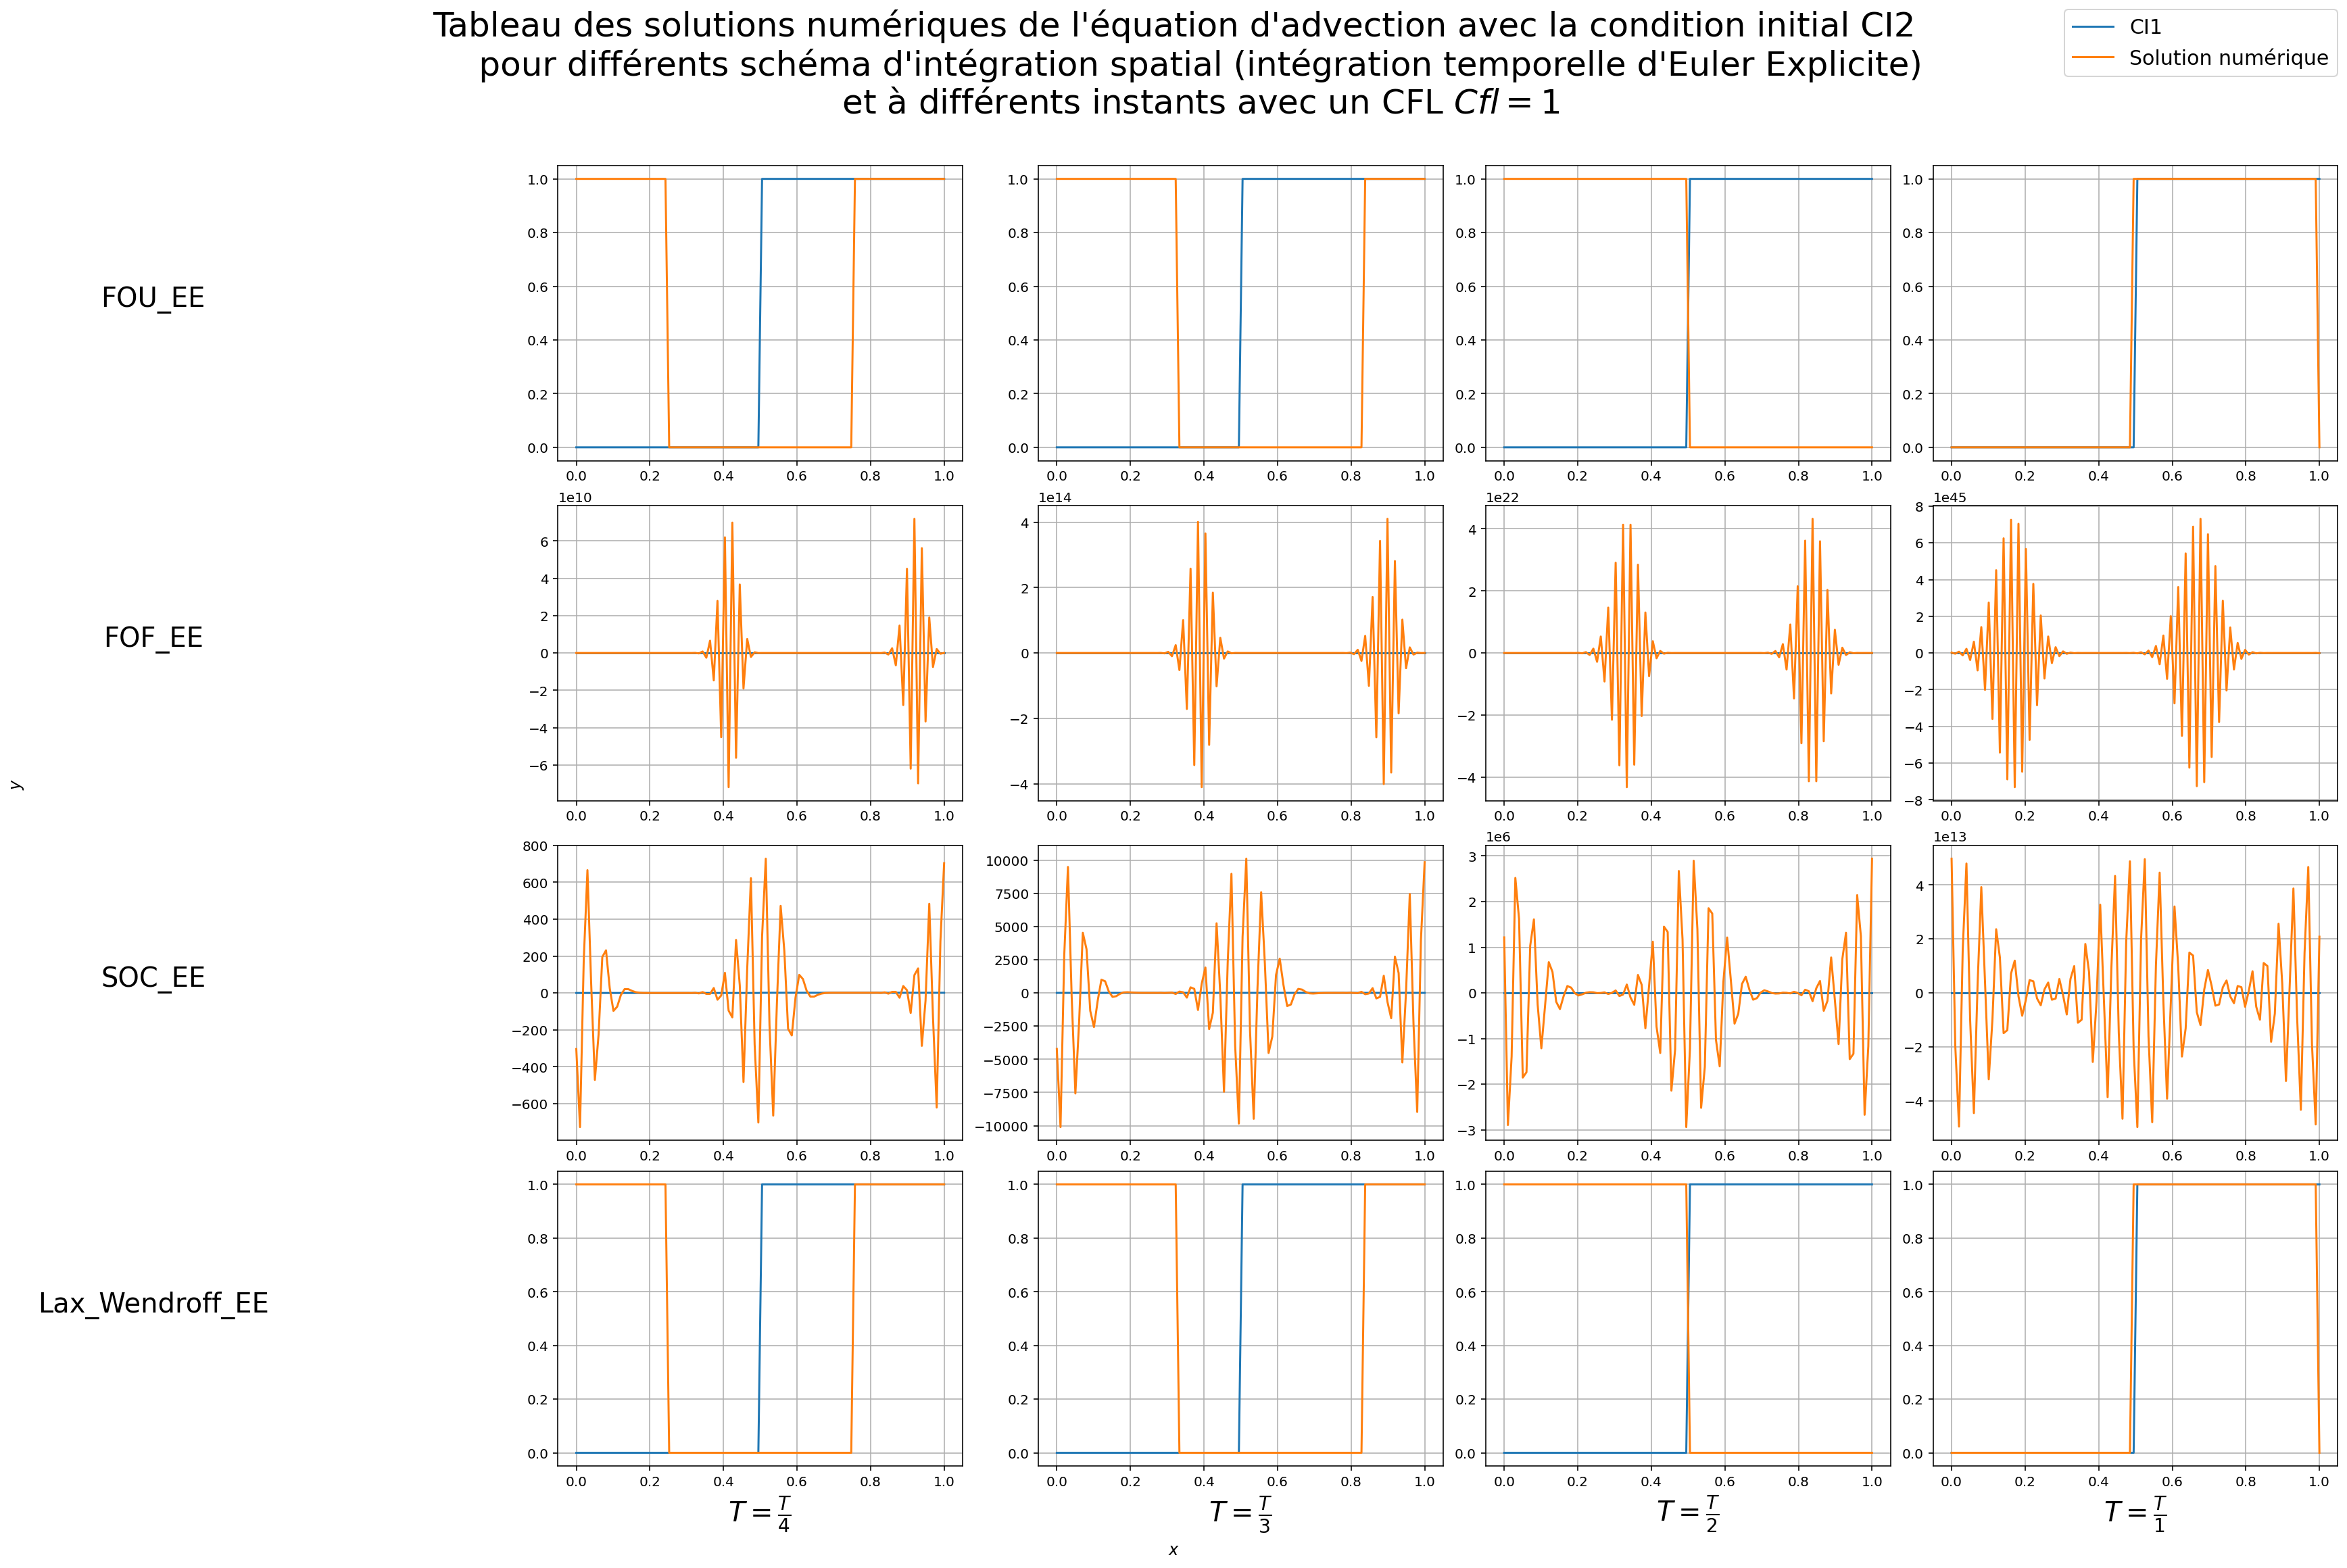

In [15]:
# Solution avec la CI2 pour différents T

T_list = [4, 3, 2, 1]
schema_list = [FOU_EE, FOF_EE, SOC_EE, Lax_Wendroff_EE]

fig, axs = plt.subplots(nrows=len(schema_list),
                        ncols=len(T_list), figsize=(24, 16))
fig.suptitle(
    "Tableau des solutions numériques de l'équation d'advection avec la condition initial CI2\n \
    pour différents schéma d'intégration spatial (intégration temporelle d'Euler Explicite)\n \
    et à différents instants avec un CFL $Cfl = 1$\n", fontsize=25)
fig.supxlabel("$x$")
fig.supylabel("$y$")
for i, schema in enumerate(schema_list):
    axs[i, 0].set_ylabel(f"{schema.__name__}", rotation=0,
                         size=20)
    axs[i, 0].yaxis.set_label_coords(-1, 0.5)
    for j, P in enumerate(T_list):
        axs[-1, j].set_xlabel(f"$T = \\frac{{T}}{{{P}}}$", rotation=0,
                              size=20)
        plot_sol(schema=schema, function_name='CI2', L=1,
                 m=100, C=1.0, a=1.0, beta=1, x0=0.5, P=P, ax=axs[i, j])

fig.legend([f"CI1", f"Solution numérique"], fontsize=15)
plt.show()


Pour `FOU_EE` et `Lax_Wendroff_EE`: La solution semble être parfaitement identique à la condition initiale.

Pour `FOF_EE` et `SOC_EE`: Ce sont des simulacres, plus le temps passe plus ils sont amplifiées (facteur amplification $G > 1$).

- Refaire l’étude sur l’influence du nombre $\mathcal{C}$ avec la condition initiale CI2.


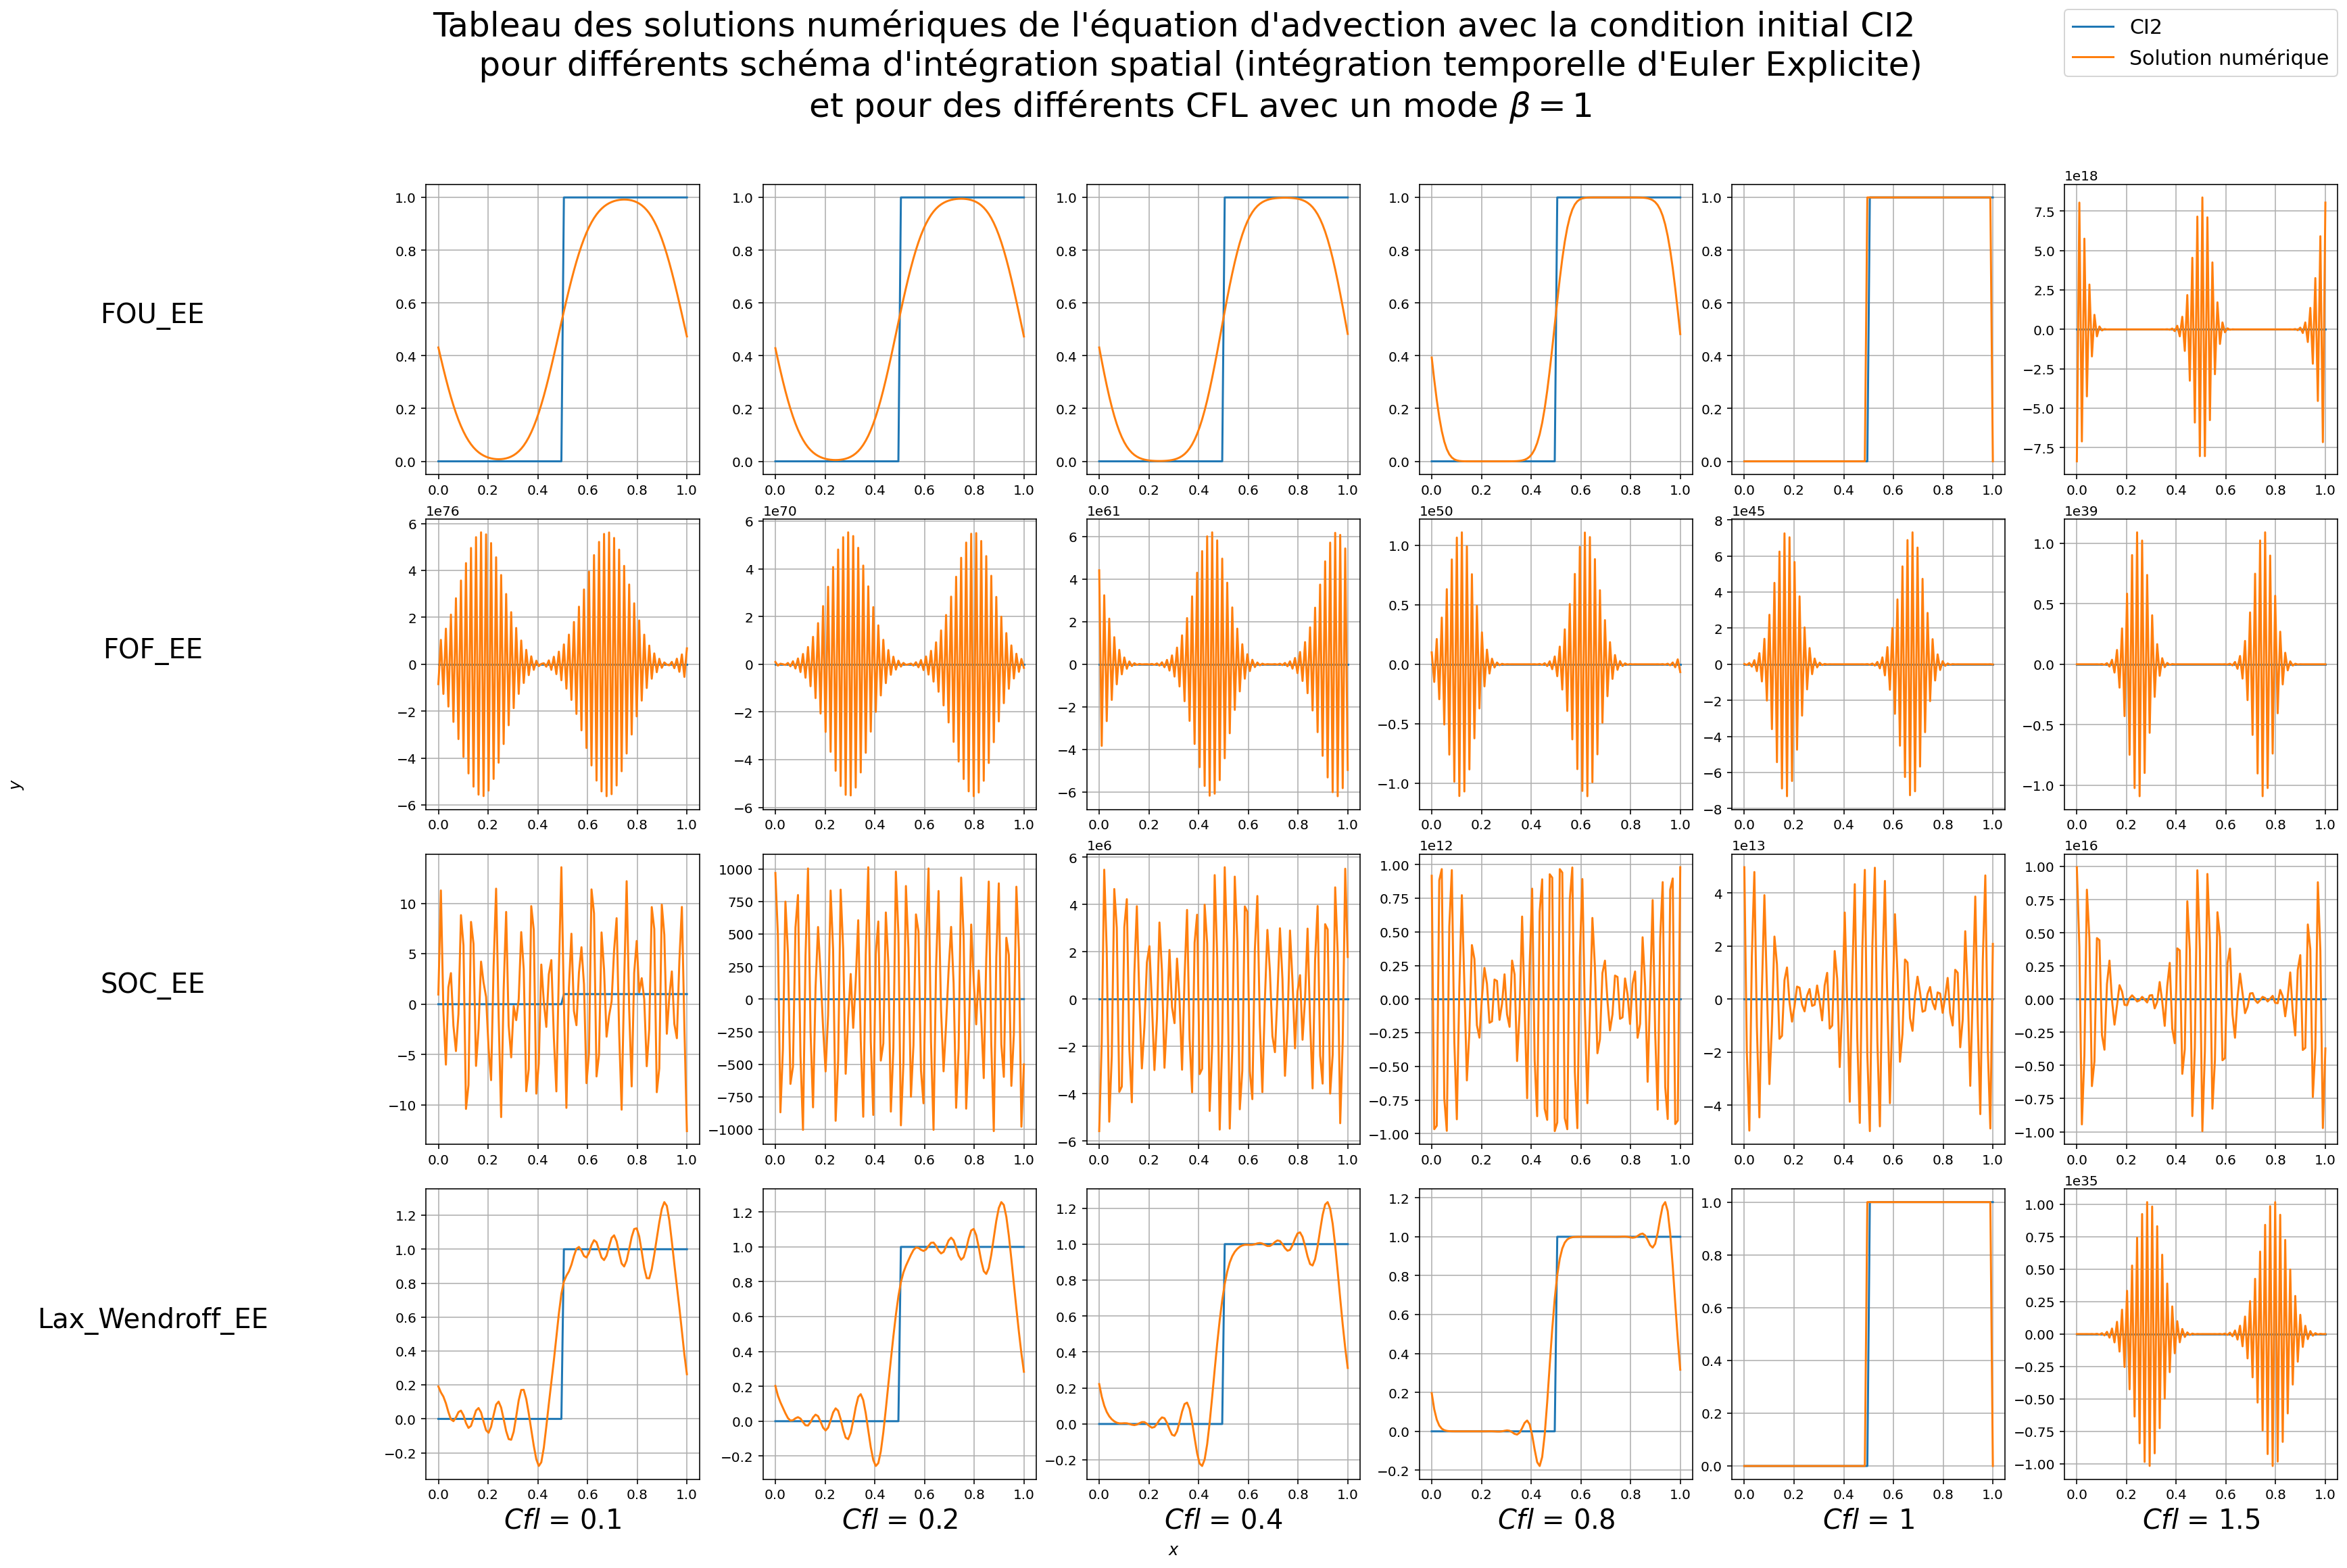

In [16]:
# Solution avec la CI2 pour différents CFL

cfl_list = [0.1, 0.2, 0.4, 0.8, 1, 1.5]
schema_list = [FOU_EE, FOF_EE, SOC_EE, Lax_Wendroff_EE]

fig, axs = plt.subplots(nrows=len(schema_list),
                        ncols=len(cfl_list), figsize=(24, 16))
fig.suptitle(
    "Tableau des solutions numériques de l'équation d'advection avec la condition initial CI2\n \
    pour différents schéma d'intégration spatial (intégration temporelle d'Euler Explicite)\n \
    et pour des différents CFL avec un mode $\\beta = 1$\n", fontsize=25)
fig.supxlabel("$x$")
fig.supylabel("$y$")
for i, schema in enumerate(schema_list):
    axs[i, 0].set_ylabel(f"{schema.__name__}", rotation=0,
                         size=20)
    axs[i, 0].yaxis.set_label_coords(-1, 0.5)
    for j, cfl in enumerate(cfl_list):
        axs[-1, j].set_xlabel(f"$Cfl$ = {cfl}", rotation=0,
                              size=20)
        plot_sol(schema=schema, function_name='CI2', L=1,
                 m=100, C=cfl, a=1.0, beta=1, x0=0.5, P=1, ax=axs[i, j])
fig.legend([f"CI2", f"Solution numérique"], fontsize=15)
plt.show()


On ne tire pas de nouvelles conclusion par rapport aux cas **CI1**. Cependant il est beaucoup plus visible que l'intégration est d'autant meilleurs qualité que le $\mathcal{C}$ est proche de $1$.

- Toujours avec CI2 et $\mathcal{C} = 0.1$, étudiez l’influence de la discrétisation spatiale sur le résultat en prenant successivement un nombre de points $m$ égal à $4$, $10$, $20$, $50$, $100$ et $200$.

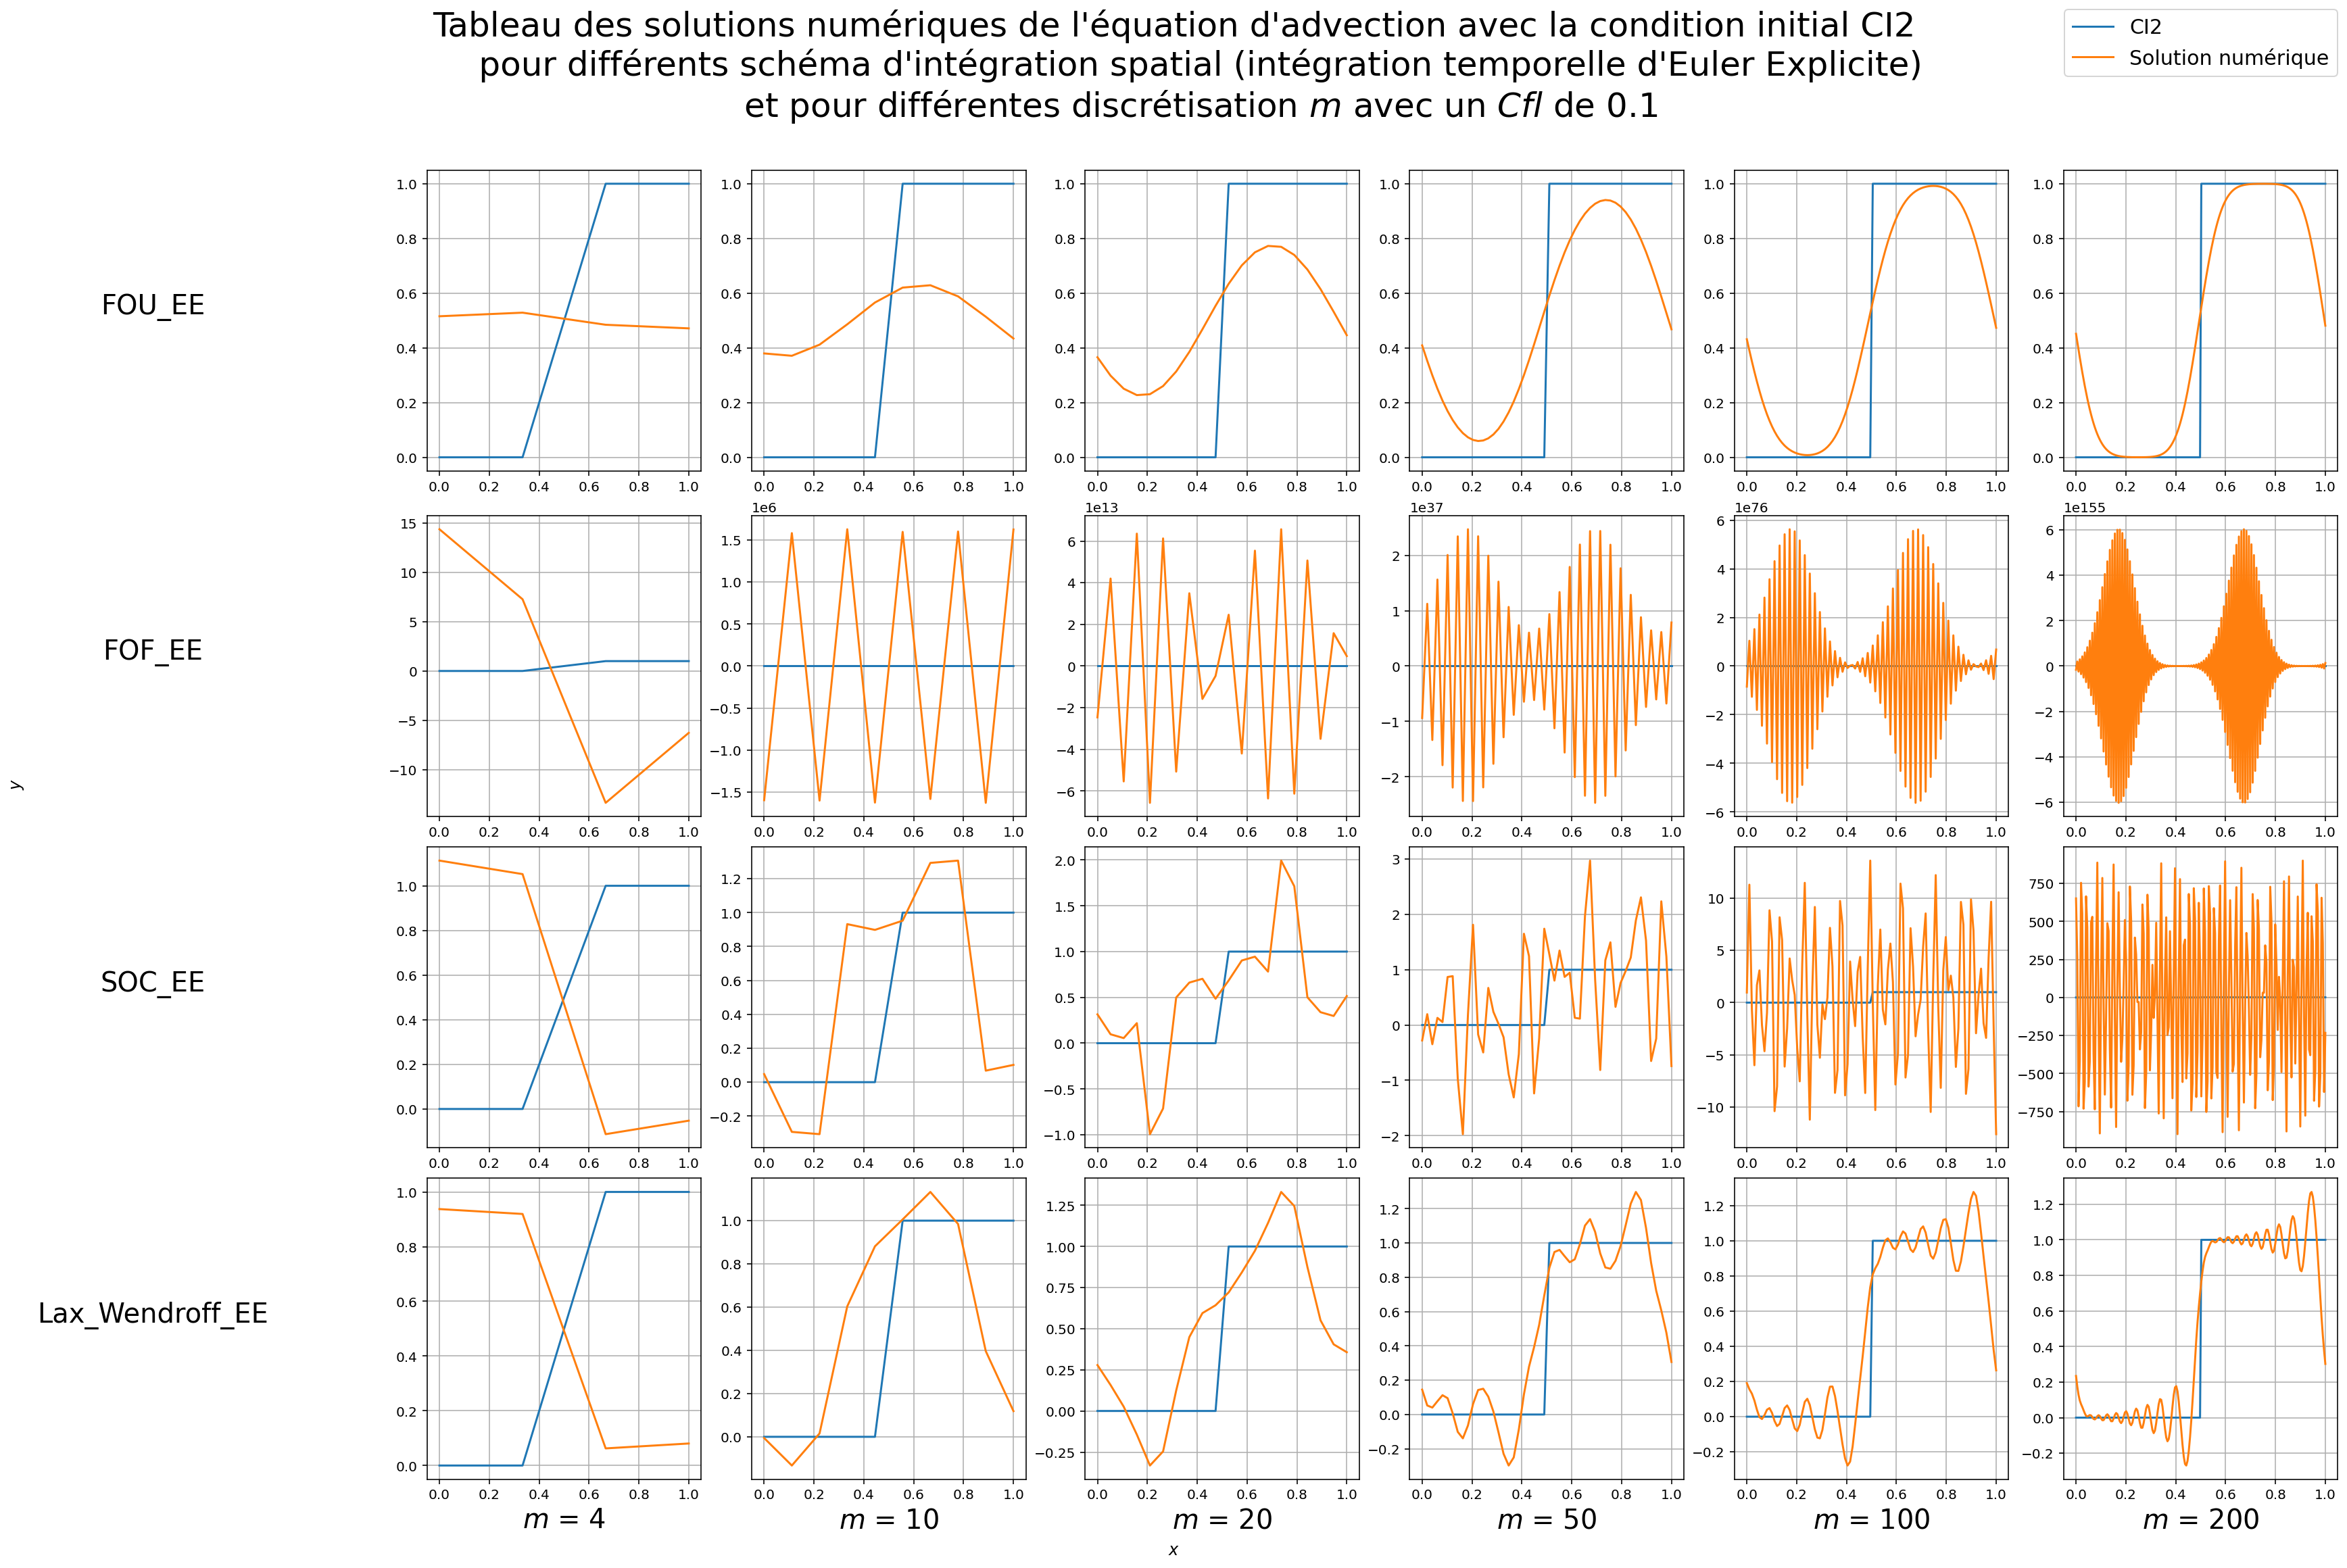

In [17]:
# Solution avec la CI2 pour différentes discrétisation spatial

m_list = [4, 10, 20, 50, 100, 200]
schema_list = [FOU_EE, FOF_EE, SOC_EE, Lax_Wendroff_EE]

fig, axs = plt.subplots(nrows=len(schema_list),
                        ncols=len(m_list), figsize=(24, 16))
fig.suptitle(
    "Tableau des solutions numériques de l'équation d'advection avec la condition initial CI2\n \
    pour différents schéma d'intégration spatial (intégration temporelle d'Euler Explicite)\n \
    et pour différentes discrétisation $m$ avec un $Cfl$ de $0.1$\n", fontsize=25)
fig.supxlabel("$x$")
fig.supylabel("$y$")

for i, schema in enumerate(schema_list):
    axs[i, 0].set_ylabel(f"{schema.__name__}", rotation=0,
                         size=20)
    axs[i, 0].yaxis.set_label_coords(-1, 0.5)
    for j, m in enumerate(m_list):
        axs[-1, j].set_xlabel(f"$m$ = {m}", rotation=0,
                              size=20)
        plot_sol(schema=schema, function_name='CI2', L=1,
                 m=m, C=0.1, a=1.0, x0=0.5, P=1, ax=axs[i, j])
fig.legend([f"CI2", f"Solution numérique"], fontsize=15)
plt.show()


Pour `FOU_EE` et `Lax_Wendroff_EE`: Ils sont stable et consistant, plus le $\Delta x$ est faible ($m$ est grand) plus les solutions numériques sont bonnes.

Pour `FOF_EE` : Il est totalement instable, la solution explose avec un ordre de $10^{155}$ pour le cas $m=200$.

Pour `SOC_EE` : Il est aussi instable mais légerement moins, il diverge dont plus lentement (ordre de $10^{2}$).

- Que se passe-t-il si l’on change le signe de a ?

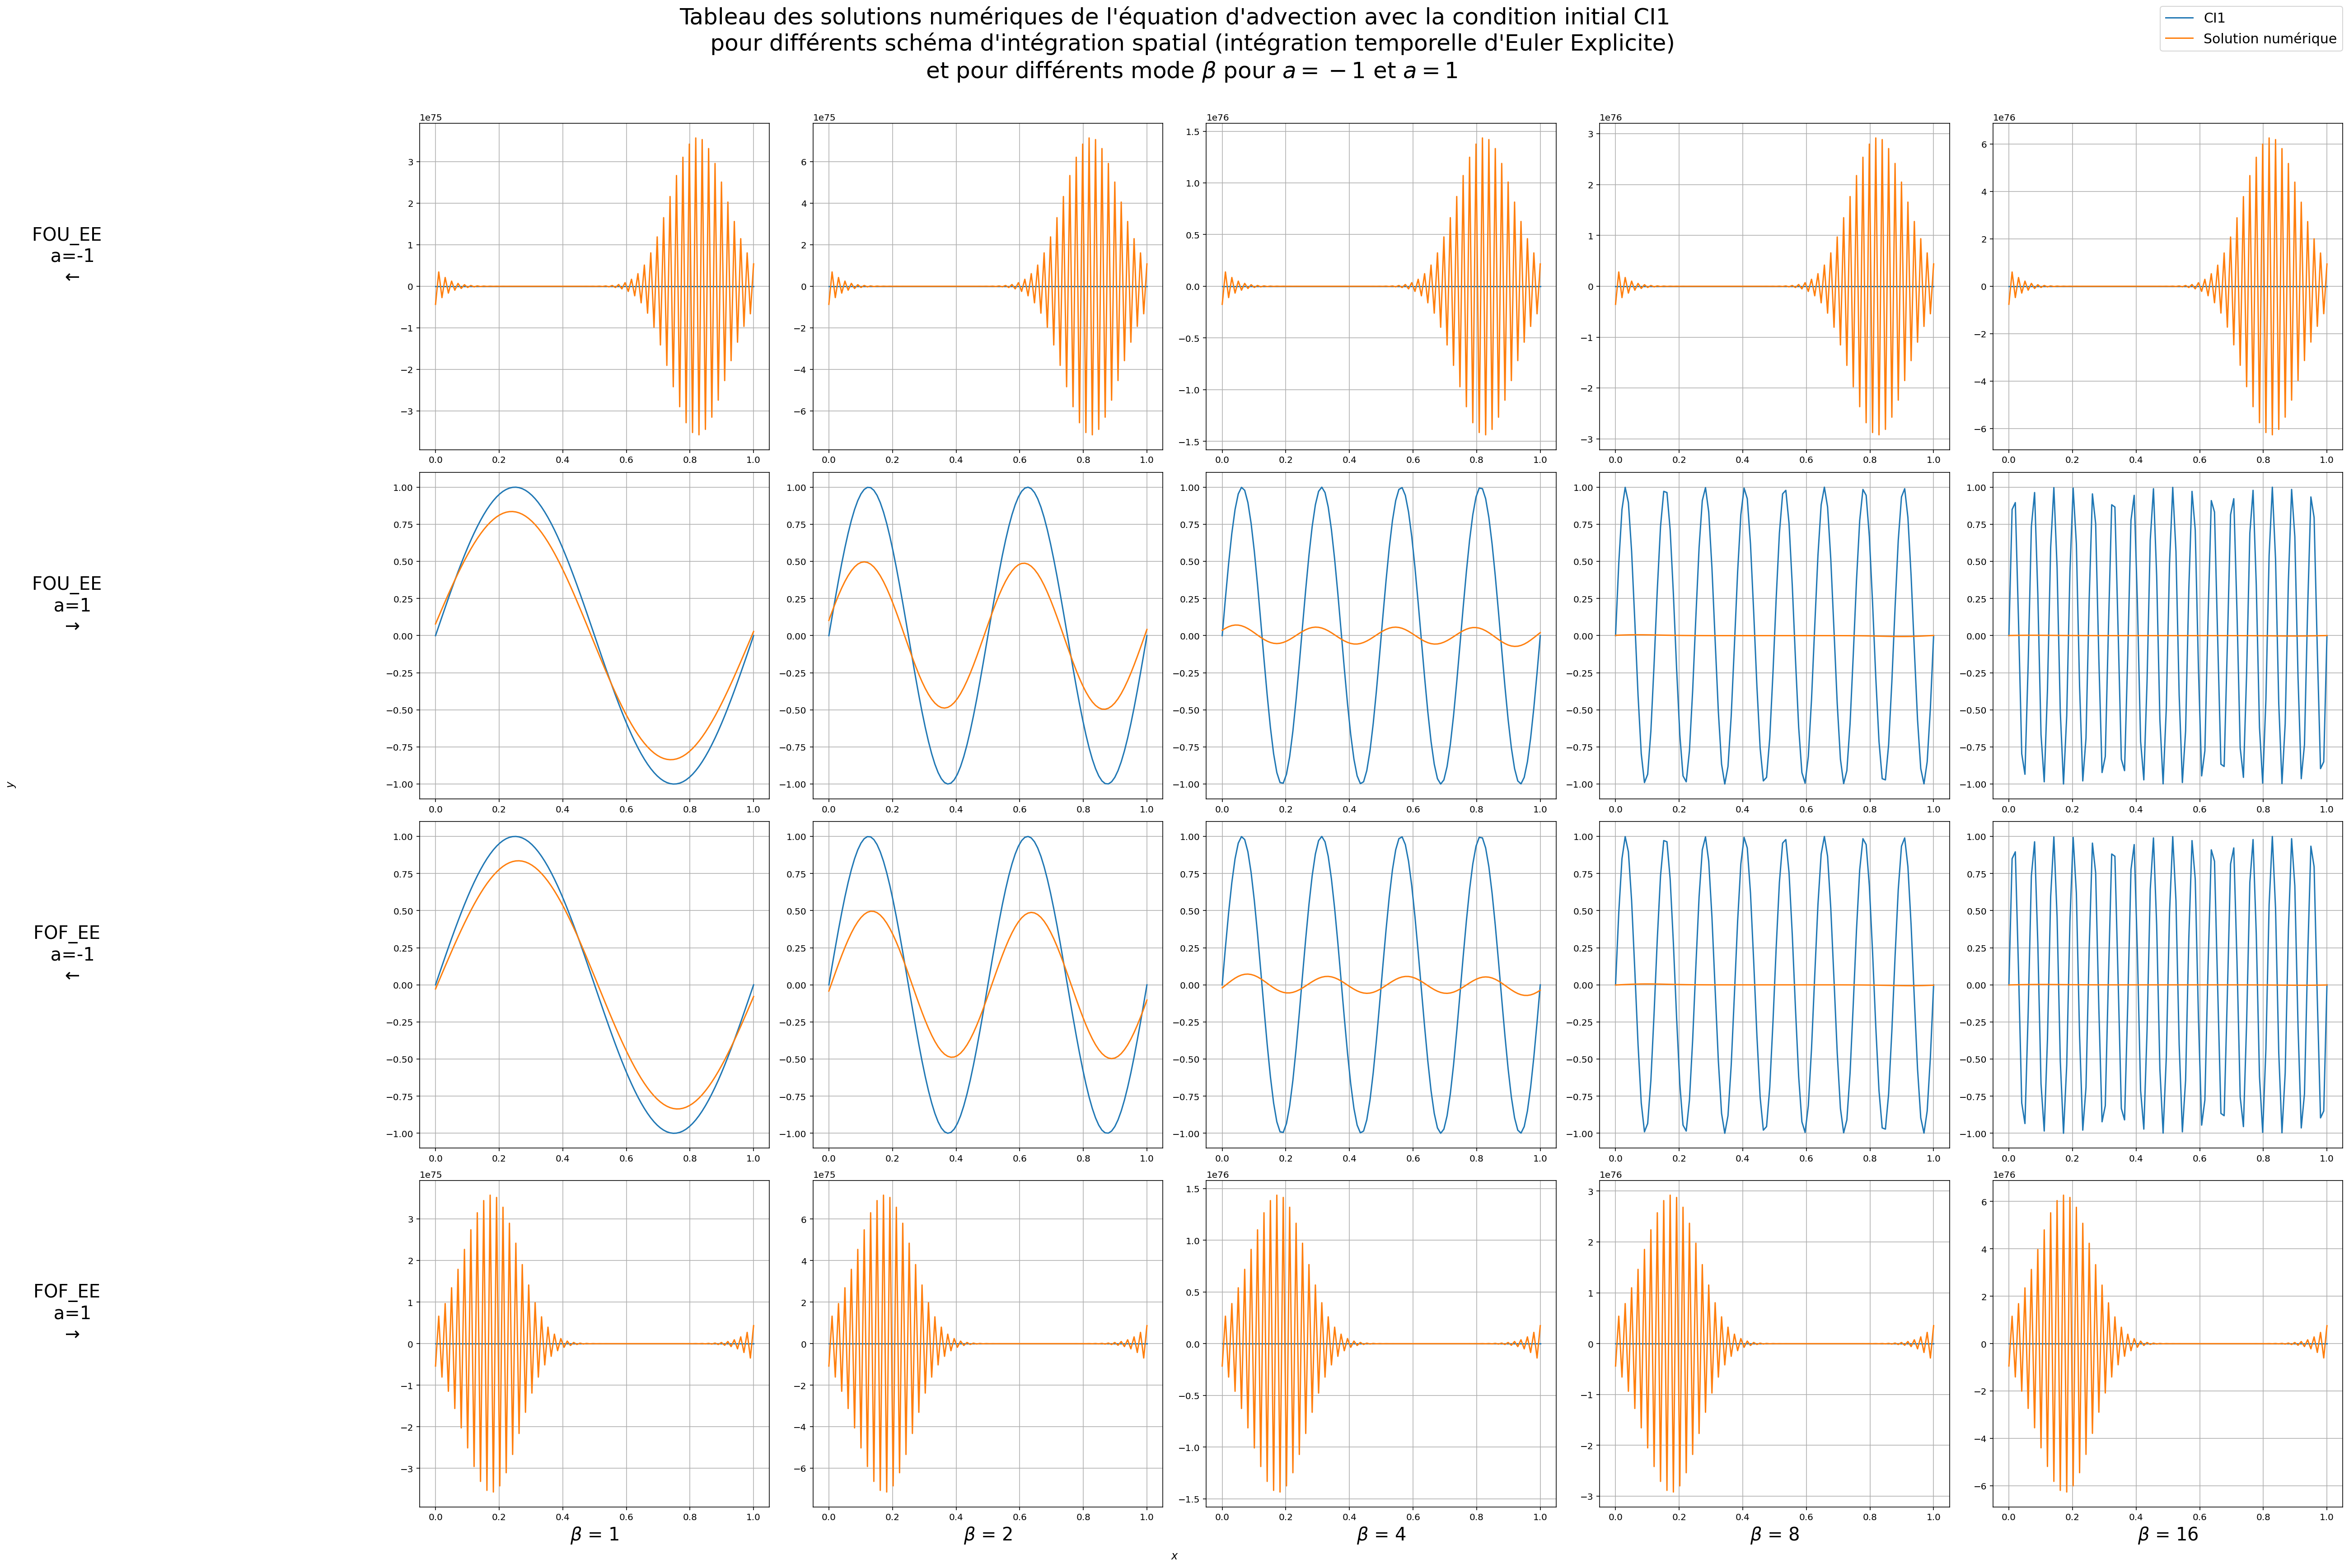

In [18]:
# Solution Beta avec changement de signe de a

a_list = [-1, +1]
beta_list = [1, 2, 4, 8, 16]
schema_list = [FOU_EE, FOF_EE]
#schema_list = [FOU_EE, FOF_EE, SOC_EE, Lax_Wendroff_EE]

fig, axs = plt.subplots(nrows=len(schema_list)*len(a_list),
                        ncols=len(beta_list), figsize=(36, 24))
fig.suptitle(
    f"Tableau des solutions numériques de l'équation d'advection avec la condition initial CI1\n \
    pour différents schéma d'intégration spatial (intégration temporelle d'Euler Explicite)\n \
    et pour différents mode $\\beta$ pour $a={a_list[0]}$ et $a={a_list[1]}$ \n", fontsize=25)
fig.supxlabel("$x$")
fig.supylabel("$y$")
for i, schema in enumerate(schema_list):
    for k, a in enumerate(a_list):
        axs[i*len(a_list)+k, 0].set_ylabel(f"{schema.__name__} \n a={a}\n {'→' if (a>0) else '←'}", rotation=0,
                             size=20)
        axs[i*len(a_list)+k, 0].yaxis.set_label_coords(-1, 0.5)
        for j, beta in enumerate(beta_list):
            axs[-1, j].set_xlabel(f"$\\beta$ = {beta}", rotation=0,
                                size=20)
            plot_sol(schema=schema, function_name='CI1', L=1,
                     m=100, C=0.1, a=a, beta=beta, x0=0.5, P=1, ax=axs[i*len(a_list)+k, j])
fig.legend([f"CI1", f"Solution numérique"], fontsize=15)
plt.show()


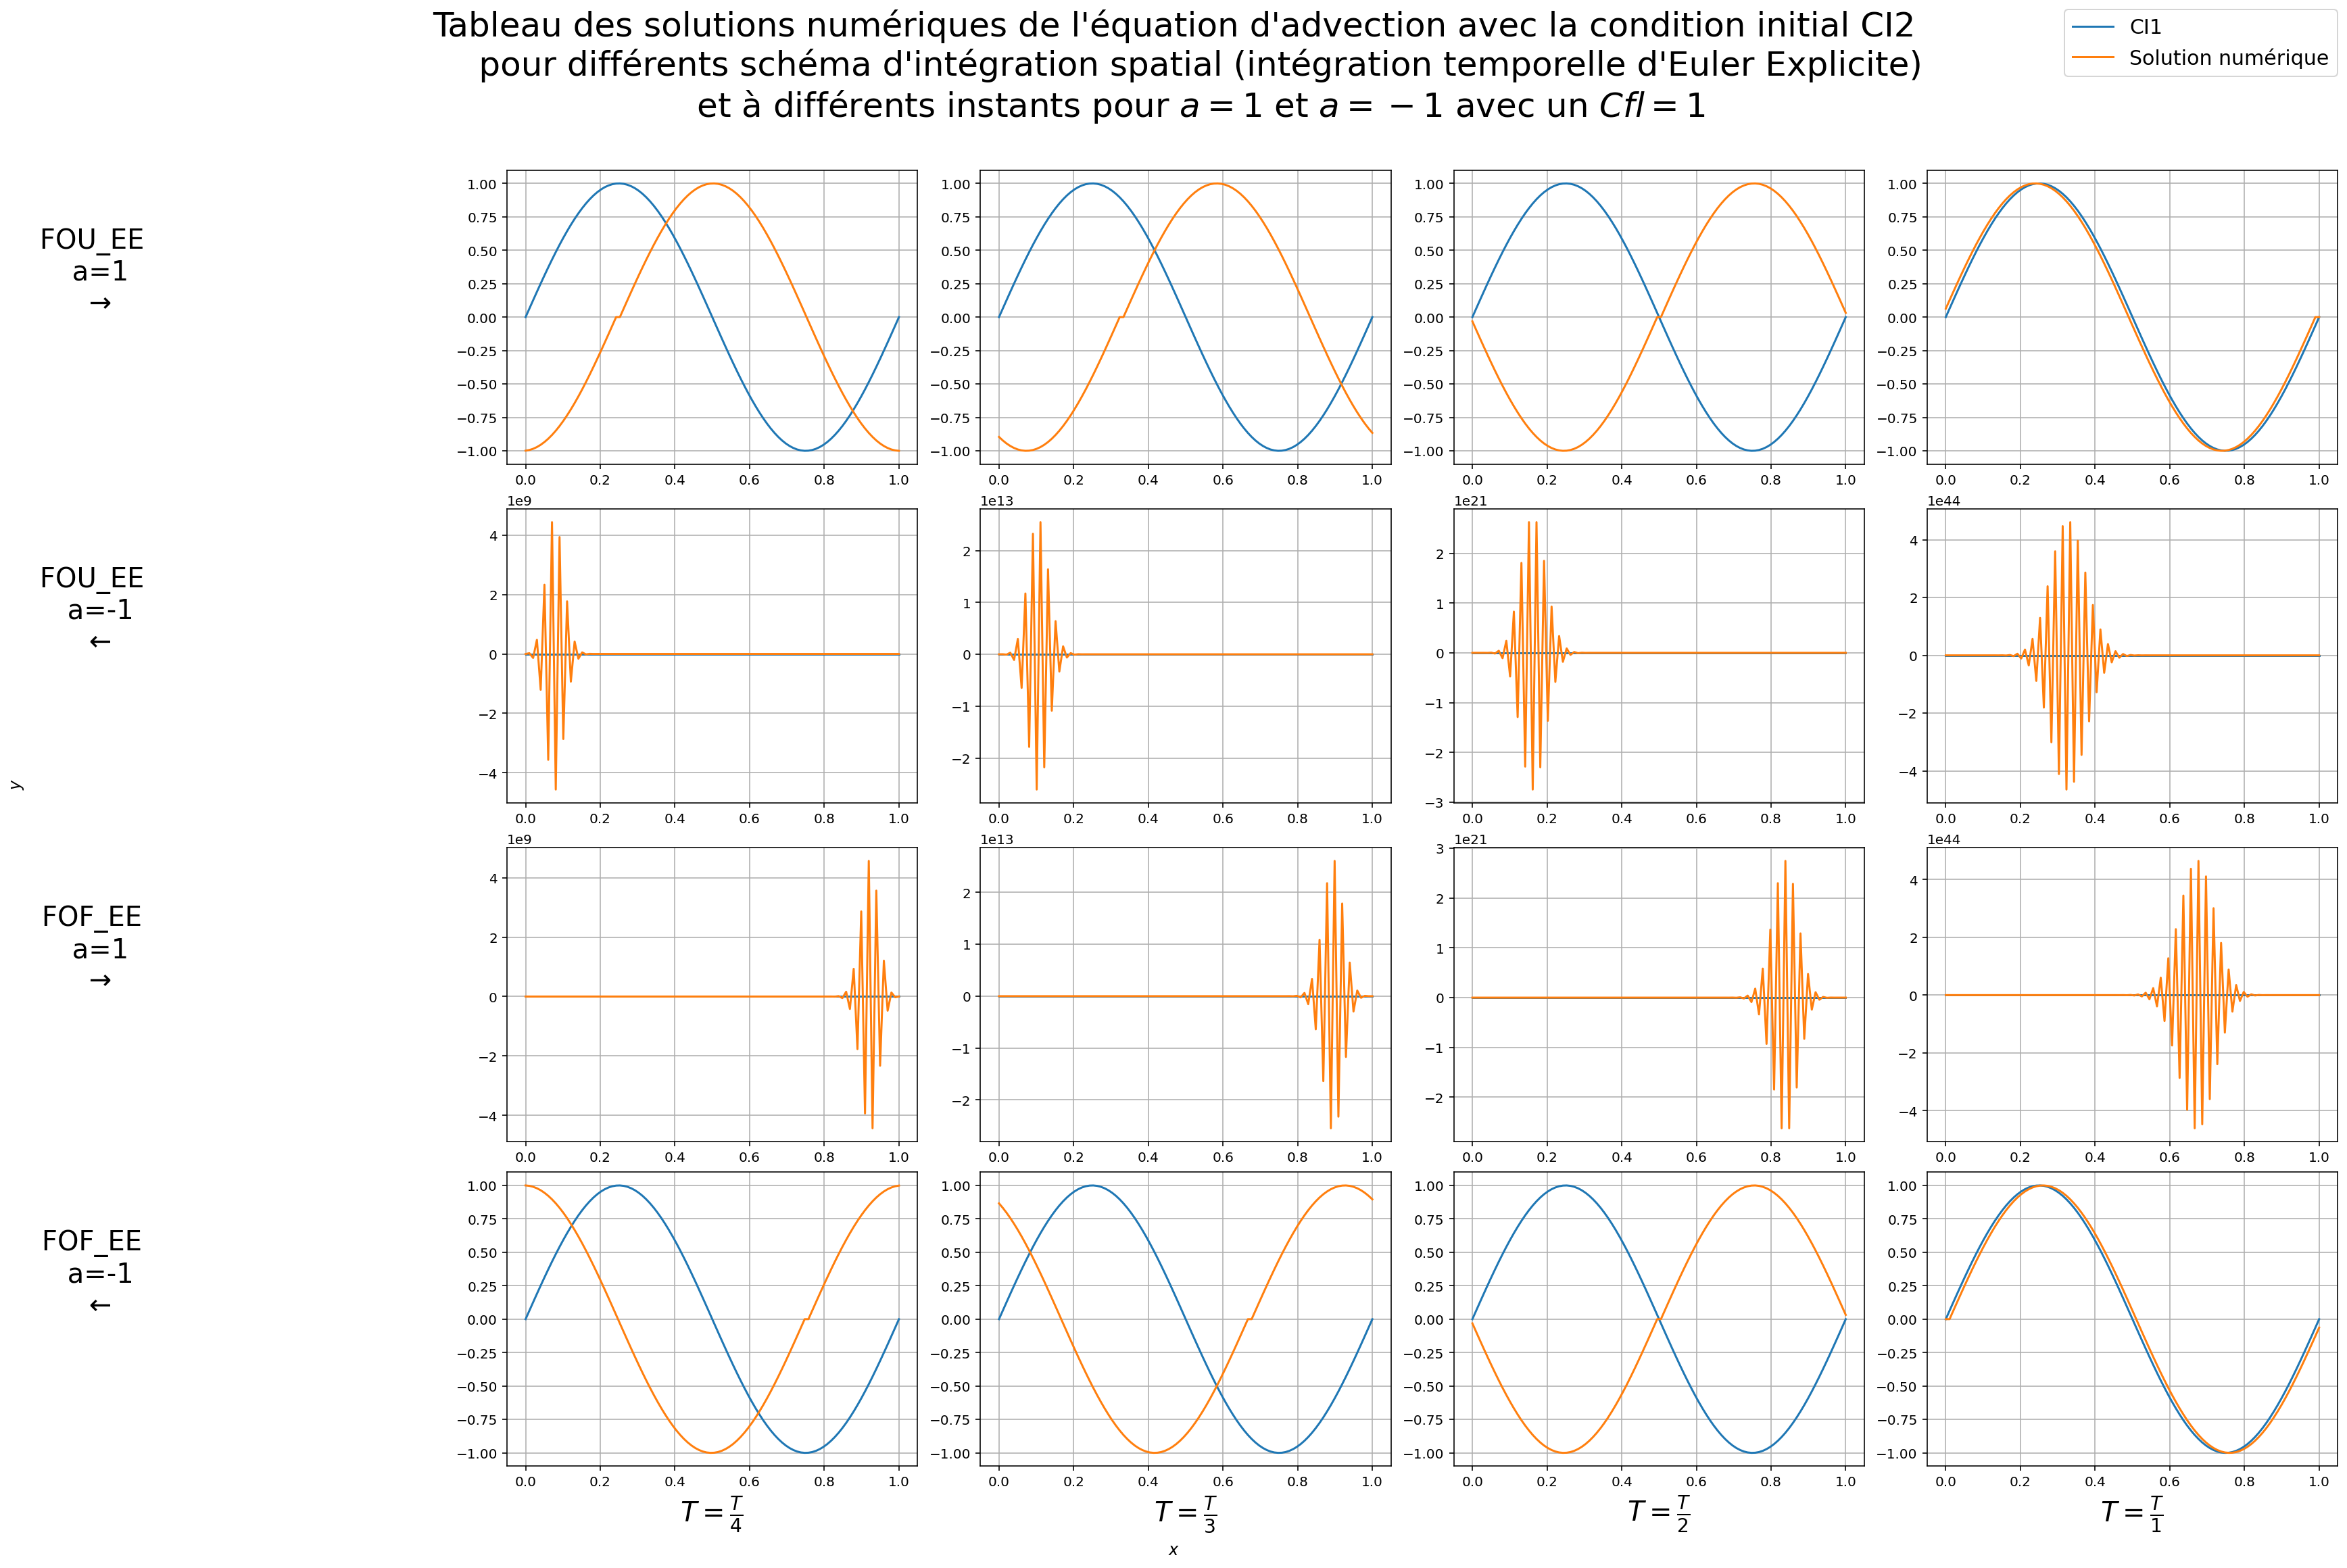

In [19]:
# Solution T avec changement de signe de a
a_list = [+1, -1]
T_list = [4, 3, 2, 1]
schema_list = [FOU_EE, FOF_EE]
#schema_list = [FOU_EE, FOF_EE, SOC_EE, Lax_Wendroff_EE]

fig, axs = plt.subplots(nrows=len(schema_list)*len(a_list),
                        ncols=len(T_list), figsize=(24, 16))
fig.suptitle(
    f"Tableau des solutions numériques de l'équation d'advection avec la condition initial CI2\n \
    pour différents schéma d'intégration spatial (intégration temporelle d'Euler Explicite)\n \
    et à différents instants pour $a={a_list[0]}$ et $a={a_list[1]}$ avec un $Cfl = 1$\n", fontsize=25)
fig.supxlabel("$x$")
fig.supylabel("$y$")
for i, schema in enumerate(schema_list):
    for k, a in enumerate(a_list):
        axs[i*len(a_list)+k, 0].set_ylabel(f"{schema.__name__} \n a={a}\n {'→' if (a>0) else '←'}", rotation=0,
                                           size=20)
        axs[i*len(a_list)+k, 0].yaxis.set_label_coords(-1, 0.5)
        for j, P in enumerate(T_list):
            axs[-1, j].set_xlabel(f"$T = \\frac{{T}}{{{P}}}$", rotation=0,
                                size=20)
            plot_sol(schema=schema, function_name='CI1', L=1,
                     m=100, C=1.0, a=a, beta=1, x0=0.5, P=P, ax=axs[i*len(a_list)+k, j])

fig.legend([f"CI1", f"Solution numérique"], fontsize=15)
plt.show()

Lorsque $a$ est négatif (←), la propagation se fait dans le sens opposé (vers $- O_x$). On remarque aussi que pour $a$ négatif `FOF_EE` est stable et que `FOU_EE` ne l'est plus. Lorsque $a$ est positif, on retrouve l'inverse.

# 3 - Bonus : Leapfrog

### Rappel du schéma **Leapforg** (Cf TD1): Ne fonctionne pas 😩

$$\frac{u_{i}^{n+1}-u_{i}^{n-1}}{2 \Delta t}+a \frac{u_{i+1}^{n}-u_{i-1}^{n}}{2 \Delta x}=0$$

$$u_{i} ^ {n+1} = u_{i} ^ {n-1} - \frac{\mathcal{C}}{2}\left(u_{i+1} ^ {n}-u_{i-1} ^ {n}\right)$$

In [25]:
def Leapfrog(ui, ui_moins, C=0.5):
    ui_plus = ui_moins - 0.5*C*(np.roll(ui, shift=-1) -
                          np.roll(ui, shift=+1))
    return ui_plus


In [26]:
def plot_sol_leapfrog(schema=Leapfrog, schema2=Lax_Wendroff_EE, function_name='CI1', L=1, m=50, C=1.0, a=1.0, beta=1, x0=1.0, P=1,
             trace=False, save=False, show=True, ax=plt):
    X = np.linspace(start=0, stop=L, num=m)
    if function_name == "CI1":
        CI = CI1
        u0 = CI(X, beta)
    elif function_name == "CI2":
        CI = CI2
        u0 = CI(X, x0)
    else:
        CI = function_name
        u0 = CI(X)

    delta_x = L/(m-1)
    delta_t = C*delta_x/np.abs(a)
    tMax = int(1/delta_t)
    tMax = int(tMax/P)
    C = np.sign(a)*C

    # t = t_0
    ut = u0
    ax.plot(X, ut)
    ut_plus = schema2(ut, C)

    # t = t_i
    for t in range(tMax):
        ut = schema(ut, ut_plus, C)
        if trace:
            plt.plot(X, ut, c=(t/tMax, 0., 0.), alpha=0.1)

    # t = t_max
    ut = schema(ut, C)
    ax.plot(X, ut)
    if ax == plt:
        ax.title(
            f"{CI.__name__}, {schema.__name__}, {schema2.__name__}, L={L}, m={m}, C={C}, a={a}, beta={beta}, x0={x0}, Tmax{P}")
        if save:
            ax.savefig(
                f"{CI.__name__}__{schema.__name__}__{schema2.__name__}__L={L}__m={m}__C={C}__a={a}__beta={beta}__x0={x0}__Tmax{P}.png")
        if show:
            ax.show()

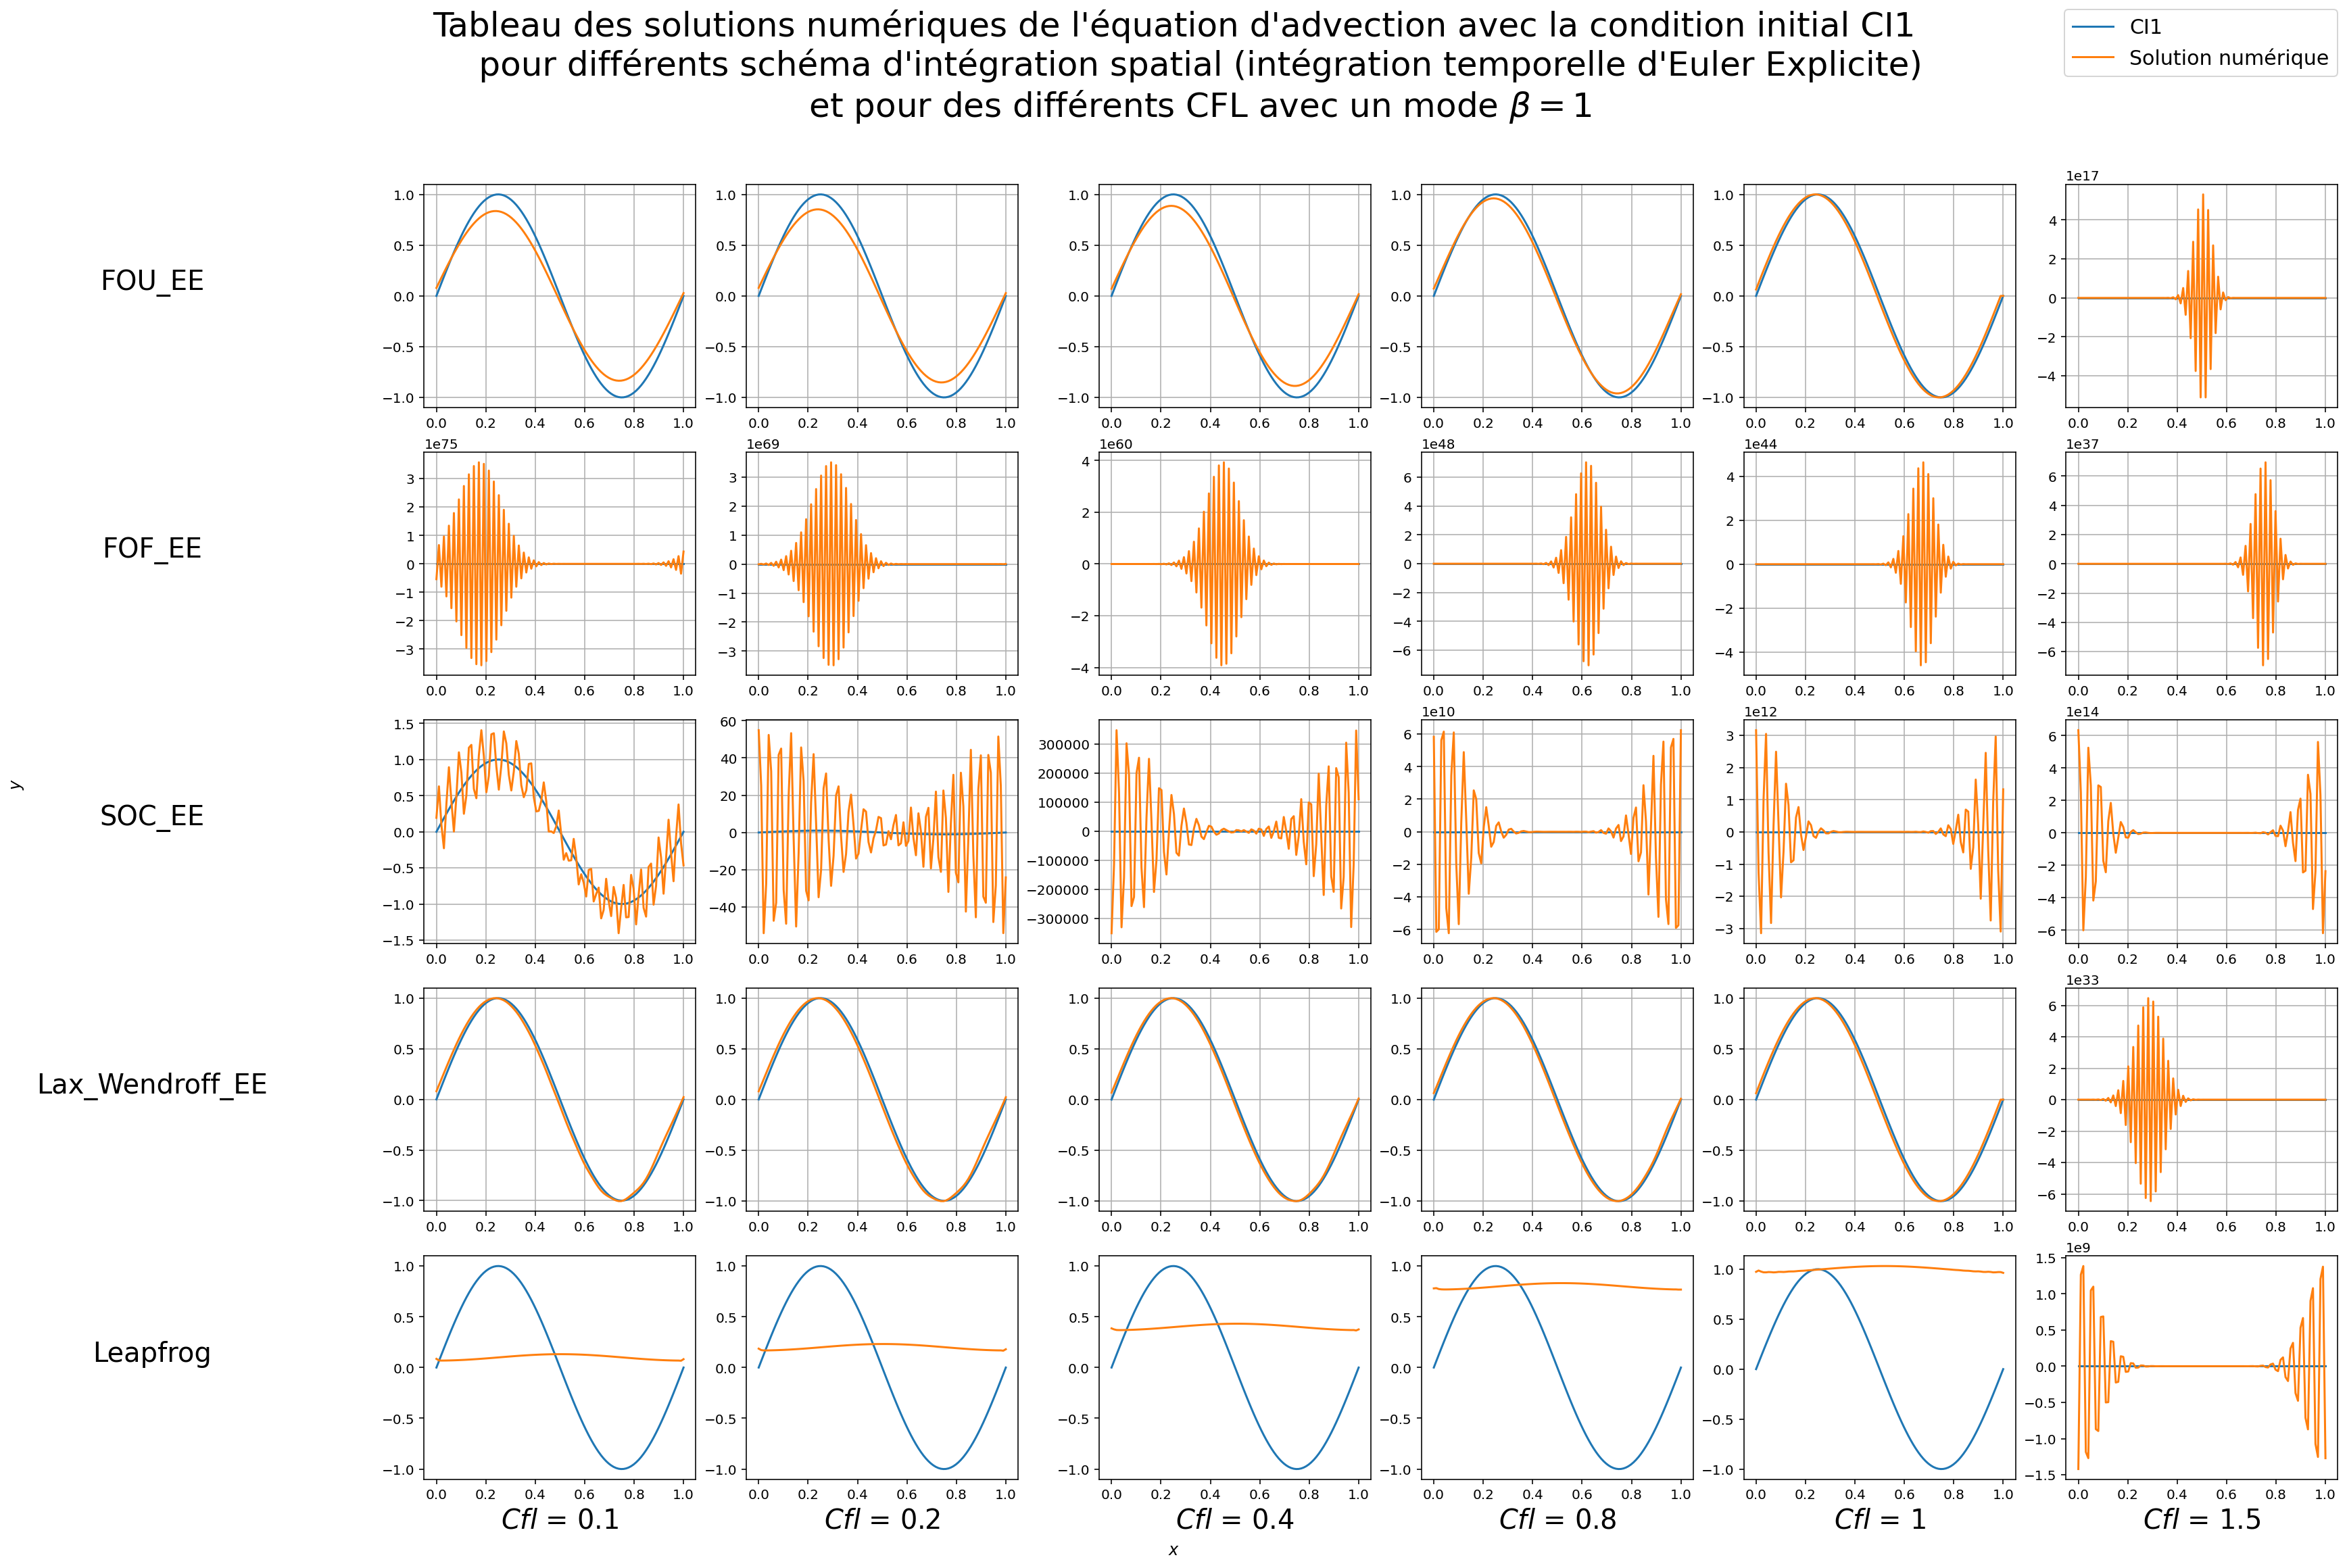

In [27]:
cfl_list = [0.1, 0.2, 0.4, 0.8, 1, 1.5]
schema_list = [FOU_EE, FOF_EE, SOC_EE, Lax_Wendroff_EE, Leapfrog]

fig, axs = plt.subplots(nrows=len(schema_list),
                        ncols=len(cfl_list), figsize=(24, 16))
fig.suptitle(
    "Tableau des solutions numériques de l'équation d'advection avec la condition initial CI1\n \
    pour différents schéma d'intégration spatial (intégration temporelle d'Euler Explicite)\n \
    et pour des différents CFL avec un mode $\\beta = 1$\n", fontsize=25)
fig.supxlabel("$x$")
fig.supylabel("$y$")
for i, schema in enumerate(schema_list):
    axs[i, 0].set_ylabel(f"{schema.__name__}", rotation=0,
                         size=20)
    axs[i, 0].yaxis.set_label_coords(-1, 0.5)
    for j, cfl in enumerate(cfl_list):
        axs[-1, j].set_xlabel(f"$Cfl$ = {cfl}", rotation=0,
                              size=20)
        if schema == Leapfrog:
            plot_sol_leapfrog(schema=schema, schema2=Lax_Wendroff_EE, function_name='CI1', L=1,
                              m=100, C=cfl, a=1.0, beta=1, x0=0.5, P=1, ax=axs[i, j])
        else:
            plot_sol(schema=schema, function_name='CI1', L=1,
                     m=100, C=cfl, a=1.0, beta=1, x0=0.5, P=1, ax=axs[i, j])
fig.legend([f"CI1", f"Solution numérique"], fontsize=15)
plt.show()
